In [1]:
import sys
sys.dont_write_bytecode = True
import os
from itertools import product
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from src.models.train_model import BTCForecasting

import pickle
import gc

from src.utils.utils import *
from src.utils.constants import *
from src.visualization.visualize import *

In [4]:
# Classifiers

classifiers = {
    'Decision_Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'RFC_balanced_subsample': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1),
}

In [5]:
# Training params

view_params = {
    'candles': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 2,
        'aggresive_elimination': False,
        'n_splits': 5,
        'classifier__max_depth': range(1, 20),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70],
    },
    'orderbook': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 2,
        'aggresive_elimination': False,
        'n_splits': 5,
        'classifier__max_depth': range(1, 20),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70],
    },
    'unified': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 2,
        'aggresive_elimination': False,
        'n_splits': 5,
        'classifier__max_depth': range(1, 20),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70],
    }
}

In [ ]:
# Import data

data = {
    (exchange, data_type): pd.read_parquet(
        os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_data.parquet')
    )
    for exchange, data_type in product(EXCHANGES, DATA_TYPES)
}
data[(ALL, UNIFIED)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{ALL}_{UNIFIED}_data.parquet'))

ground_truth = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, 'ground_truth_data.parquet'))

In [ ]:
# Training

model_params = {}

for (name, classifier) in classifiers.items():
    for (exchange, data_type), df in data.items():
        
        params = view_params[data_type]

        use_smoteenn = params['use_smoteenn']
        factor = params['factor']
        aggressive_elimination = params['aggresive_elimination']
        n_splits = params['n_splits']
        
        print(f"\nStarting training {name} model for {exchange} - {data_type}")

        btcf = BTCForecasting(
            df, 
            ground_truth,
            n_splits=n_splits,
            smoteenn=use_smoteenn,
            pca_variance_threshold=PCA_VARIANCE_THRESHOLD,
            feature_selection=params['feature_selection'],
        )

        model_params = {k: v for k, v in params.items() if k.startswith('classifier__')}

        btcf.train(classifier, model_params, factor=factor, aggressive_elimination=aggressive_elimination, verbose=3)

        save_model(btcf, name, exchange, data_type)


Best Decision_Tree model for BINANCE - candles
{'classifier__max_depth': 7, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4}


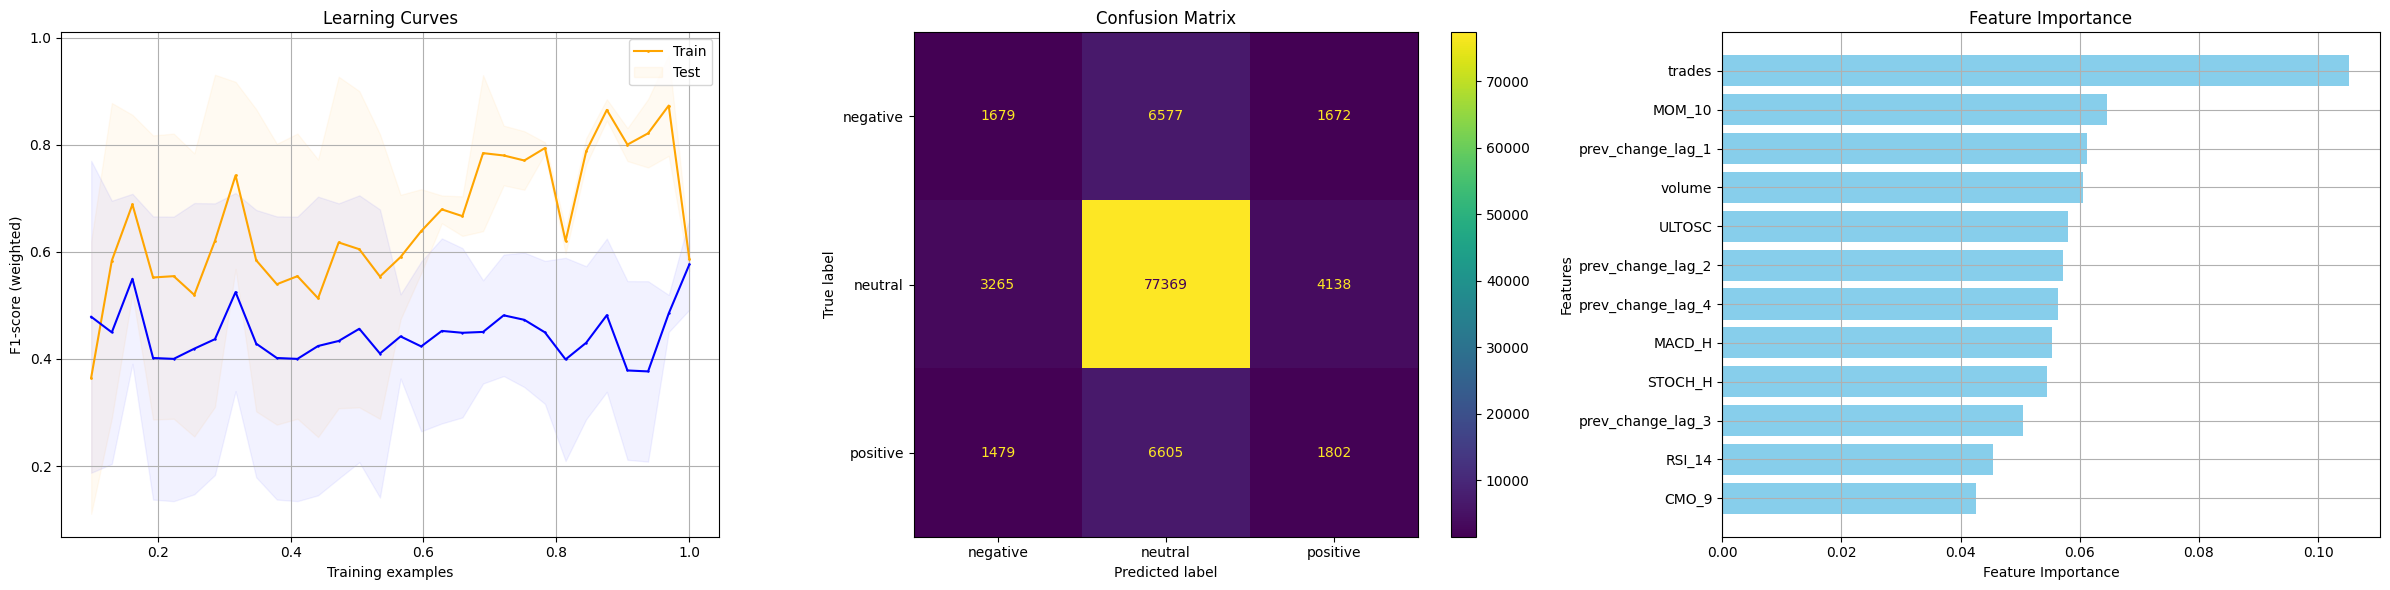

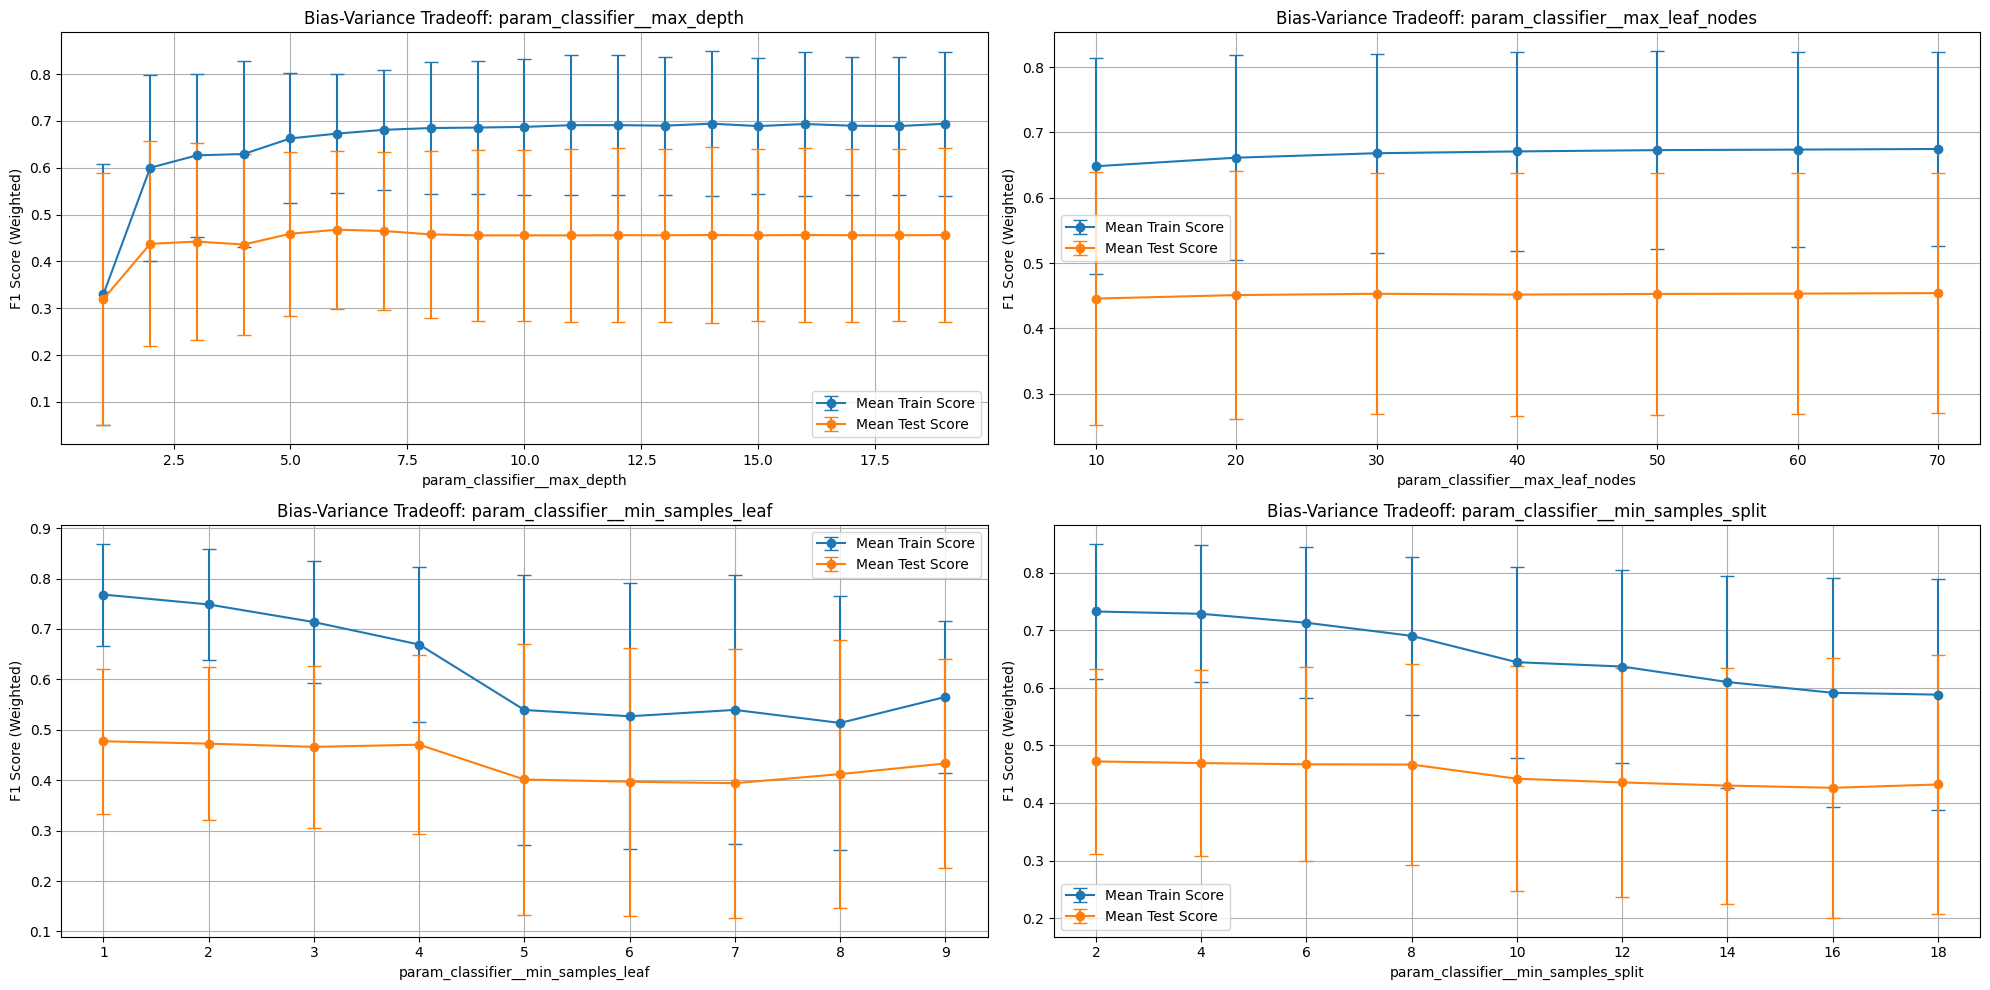


Best Decision_Tree model for BINANCE - orderbook
{'classifier__max_depth': 17, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}


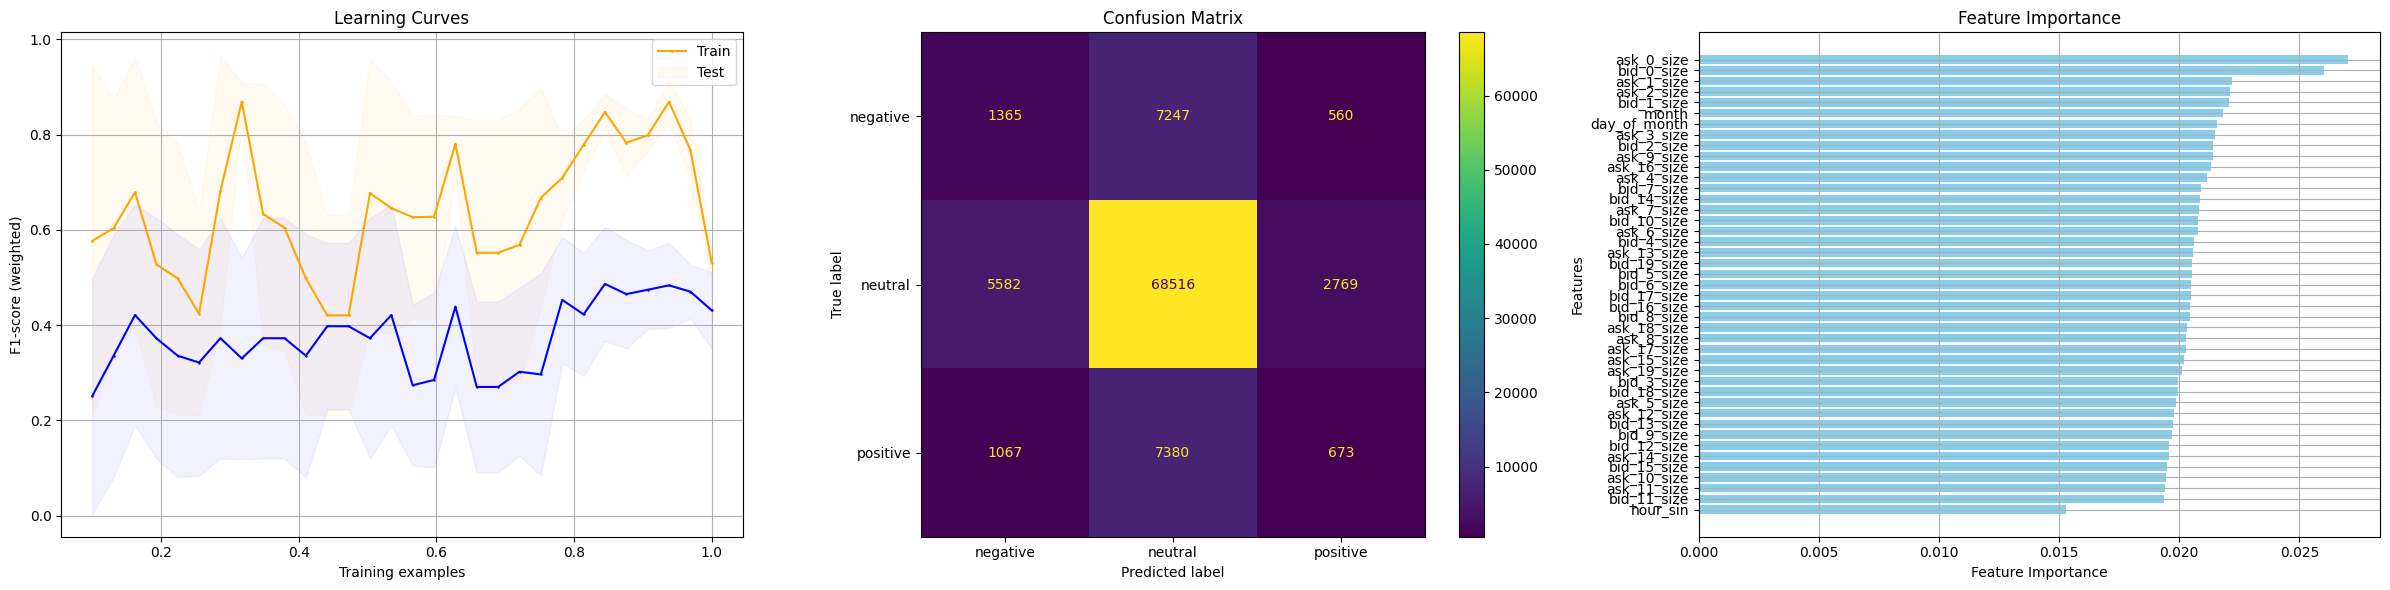

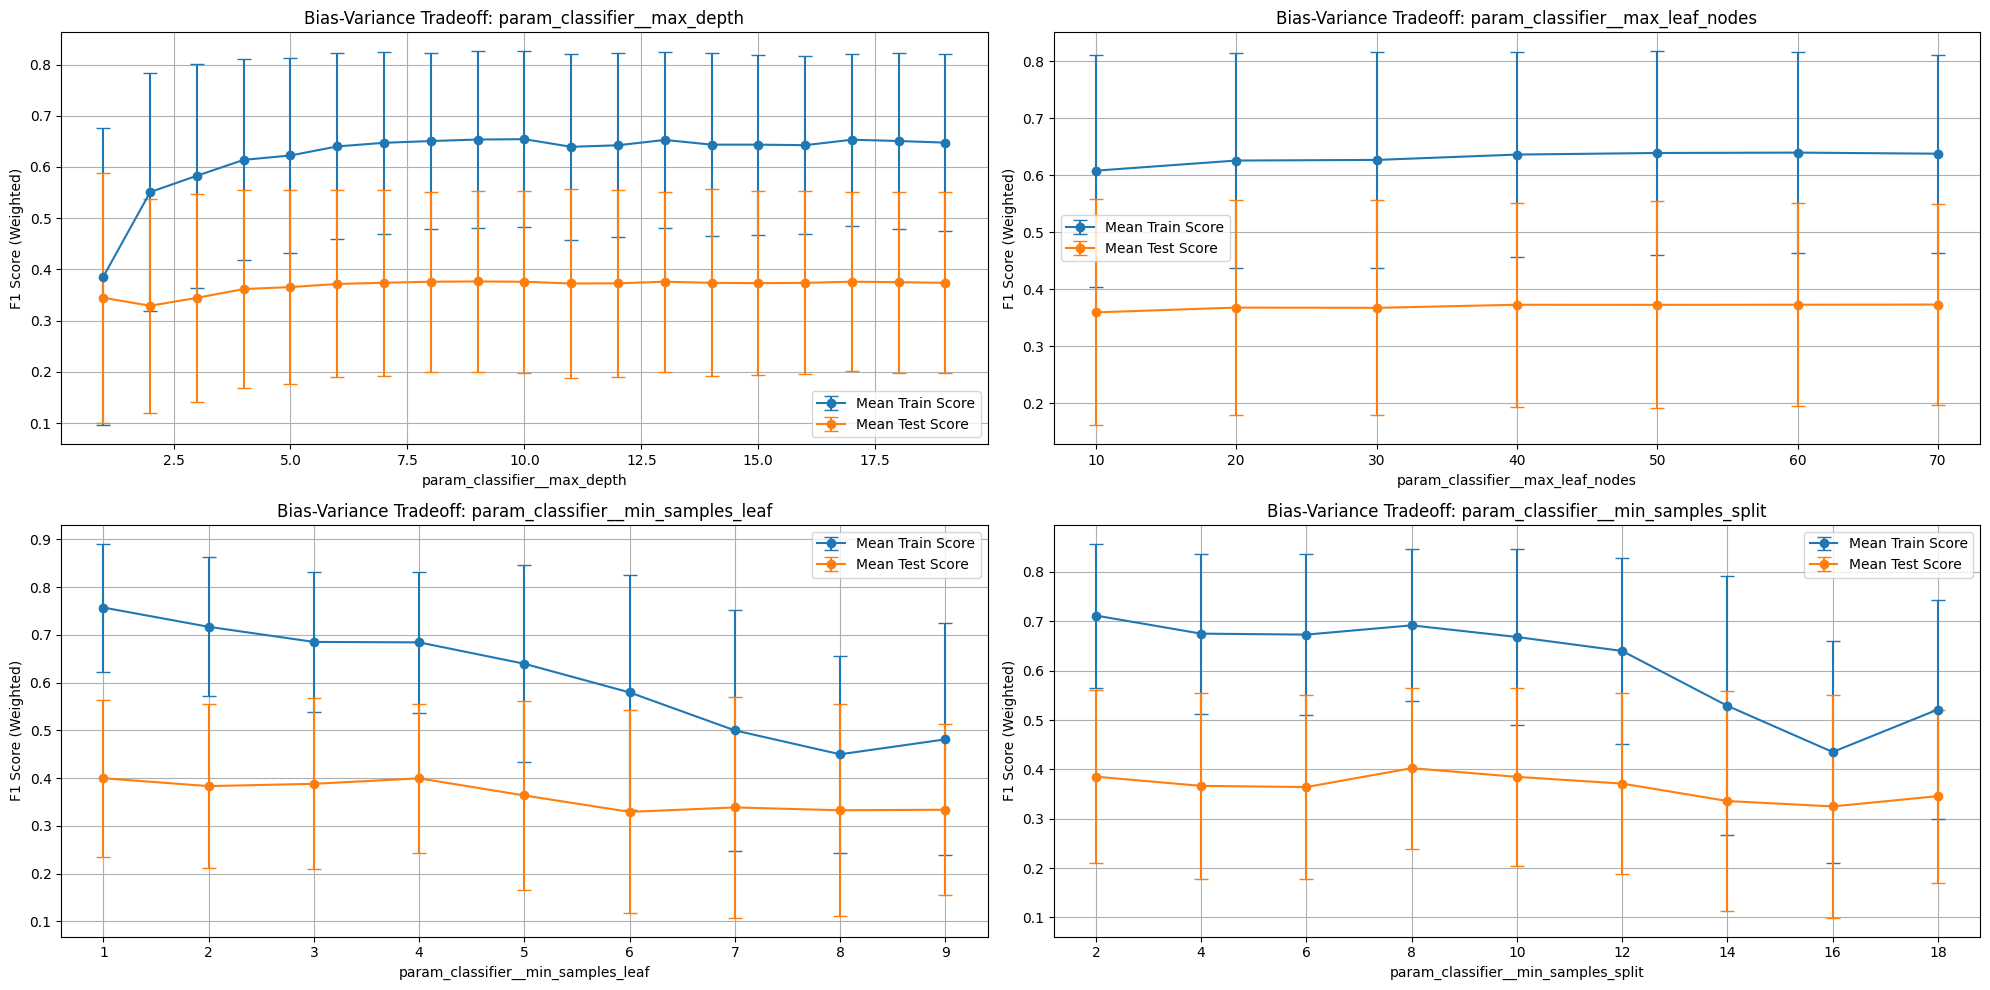


Best Decision_Tree model for BINANCE - unified
{'classifier__max_depth': 13, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 8}


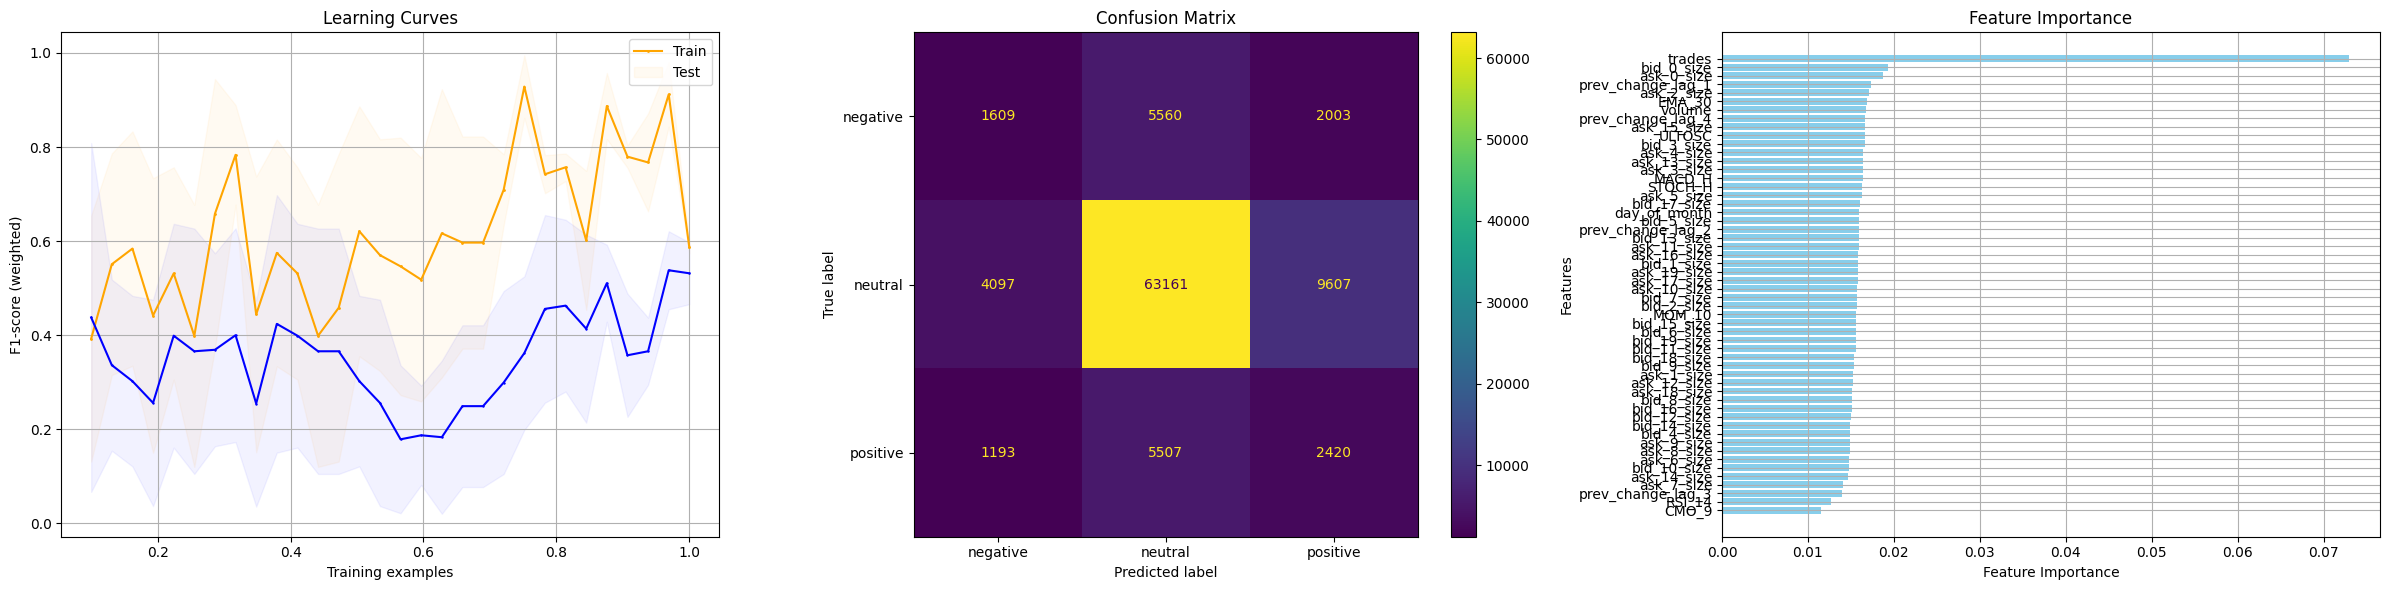

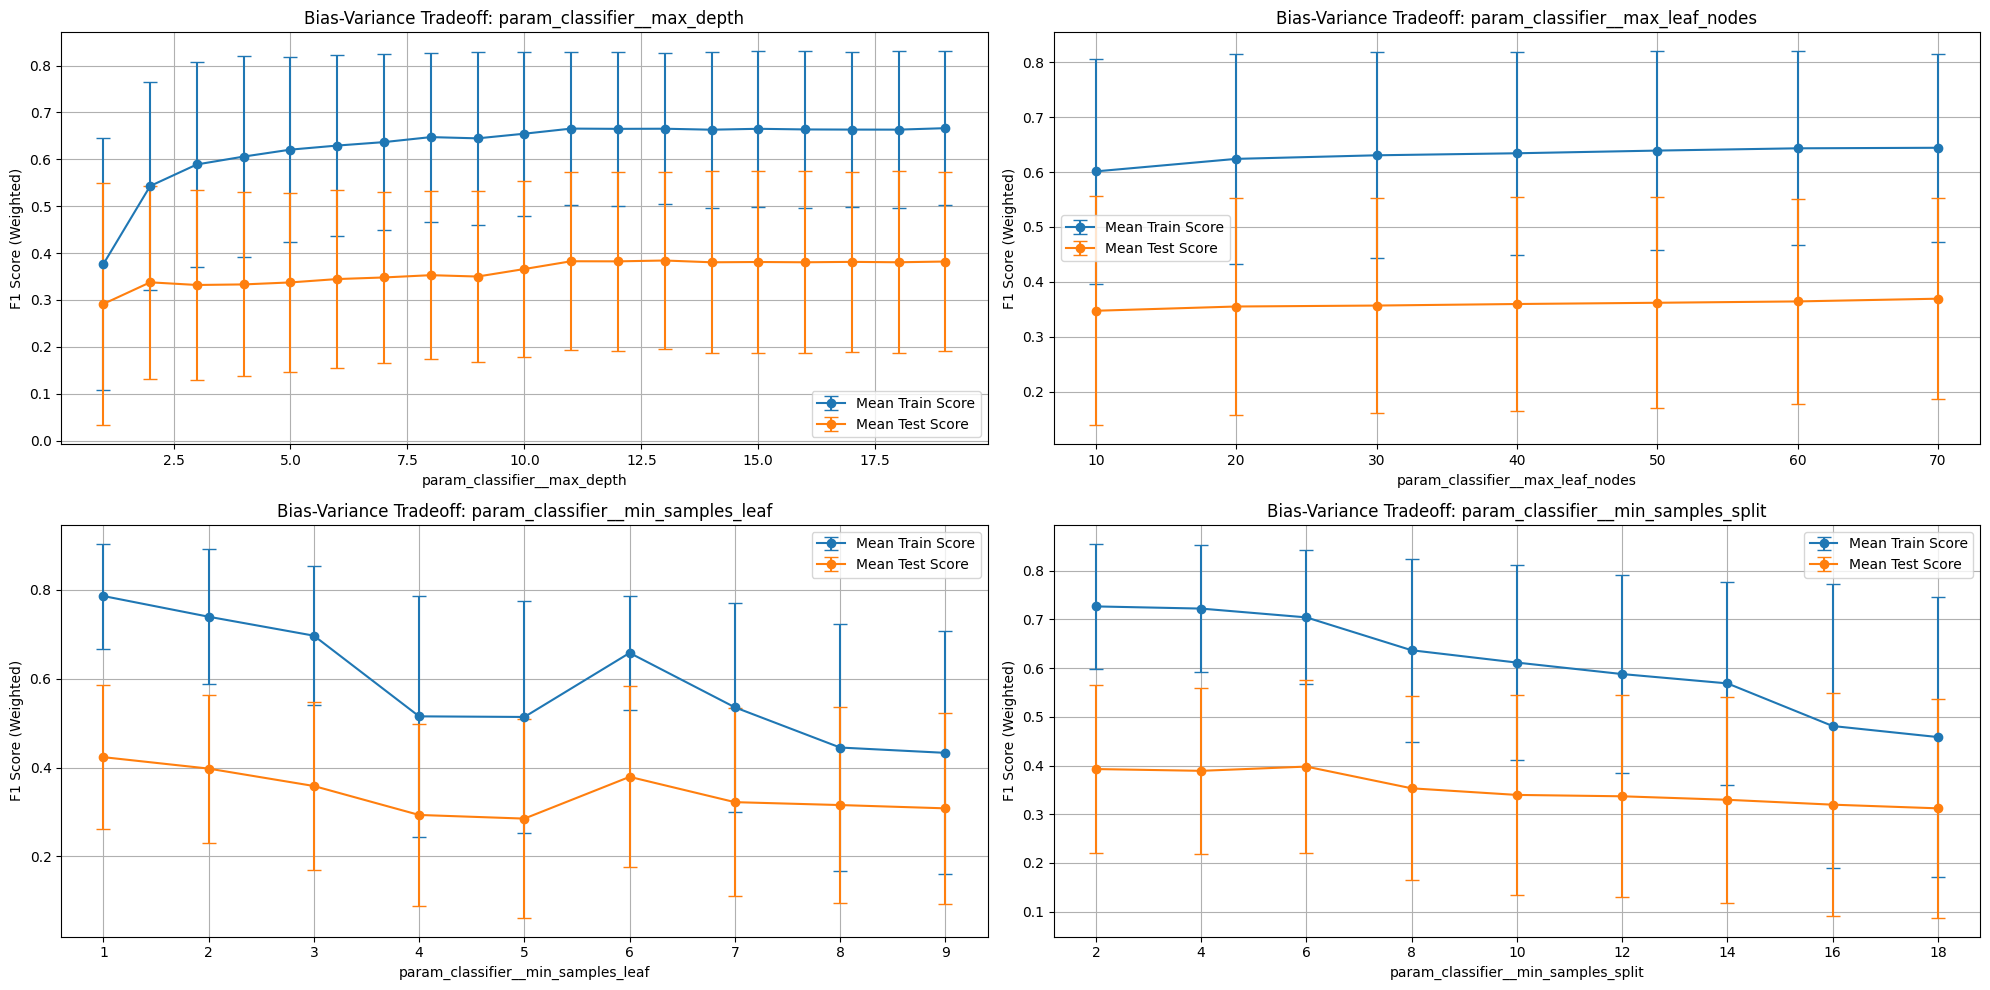


Best Decision_Tree model for HUOBI - candles
{'classifier__max_depth': 11, 'classifier__max_leaf_nodes': 60, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


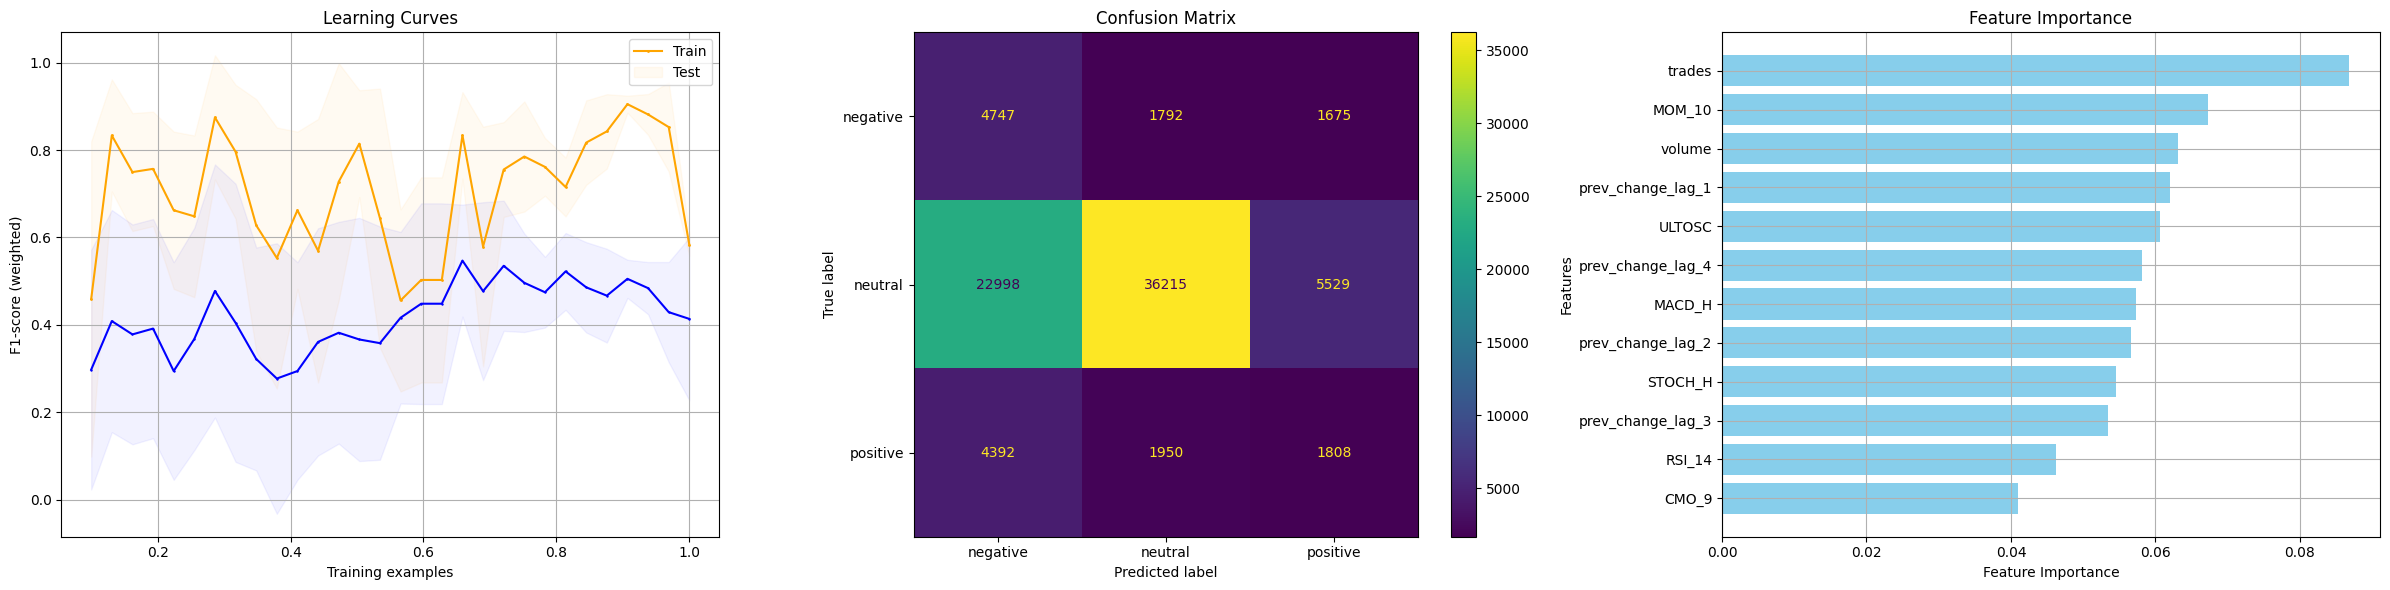

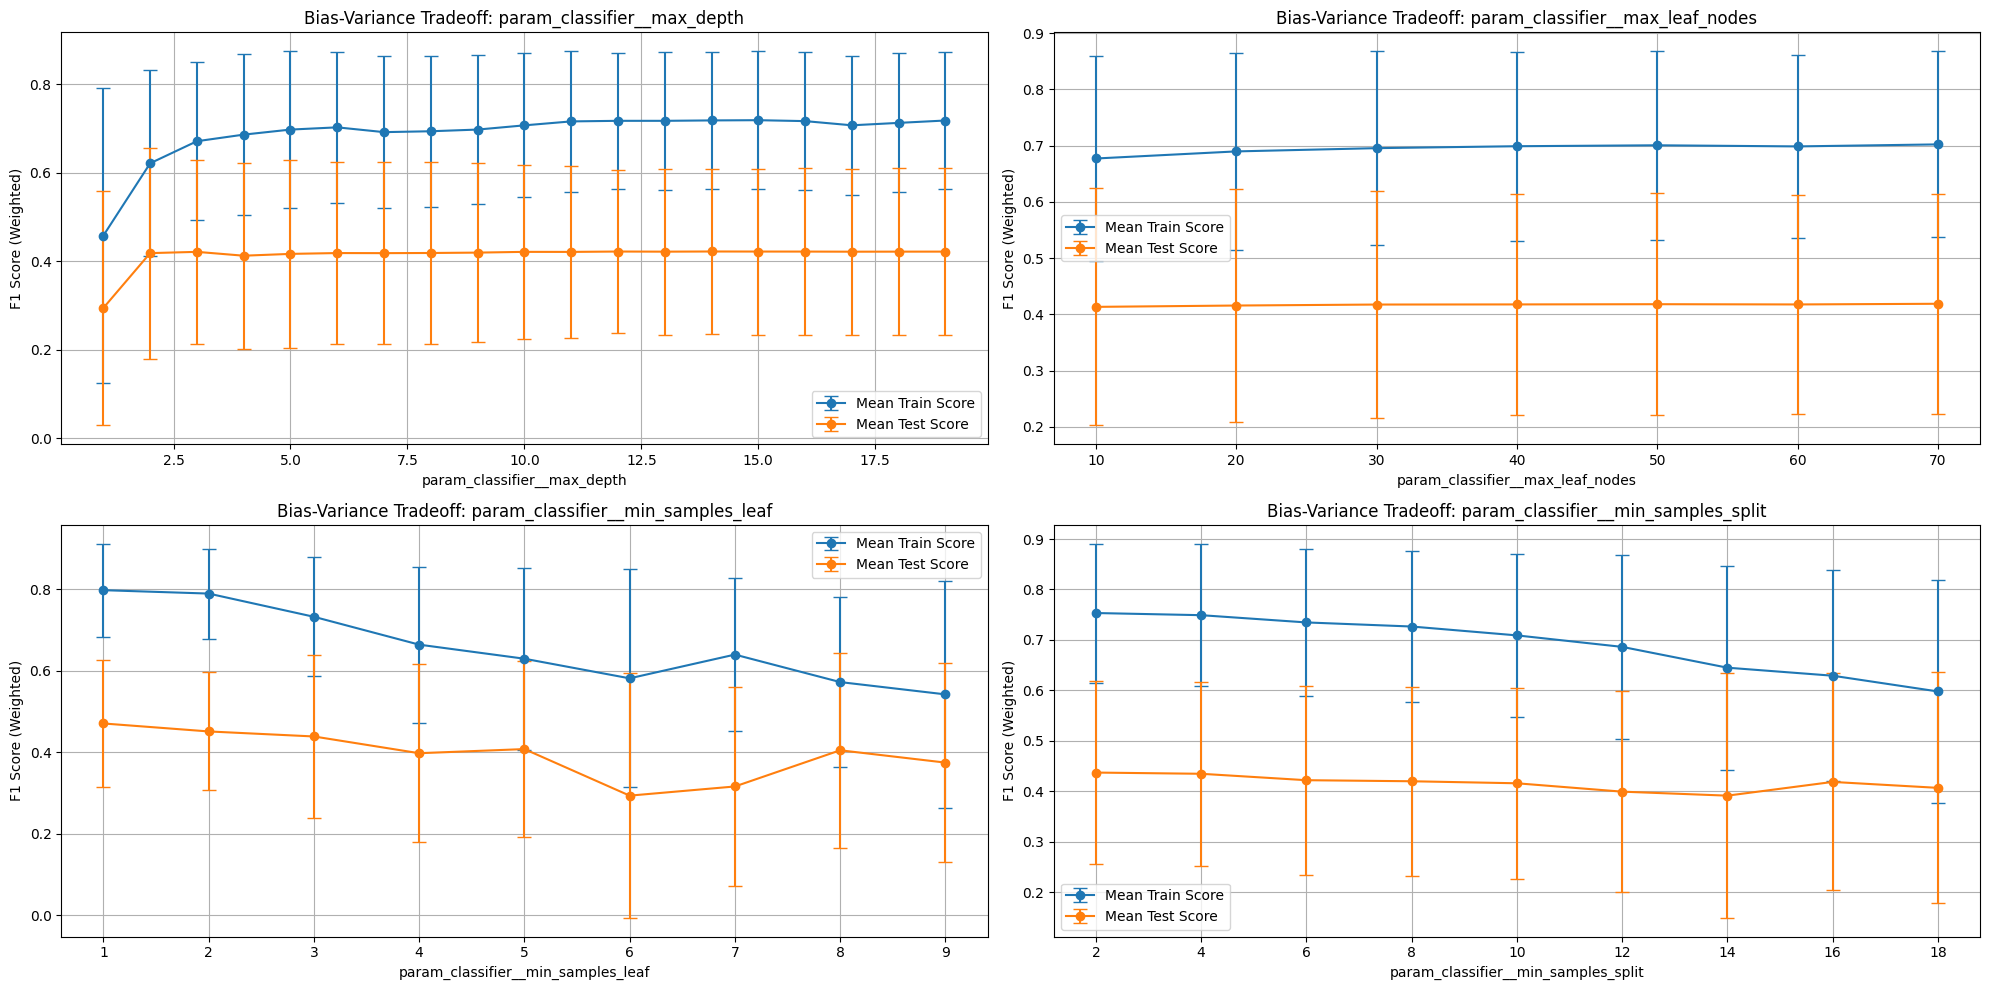


Best Decision_Tree model for HUOBI - orderbook
{'classifier__max_depth': 16, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6}


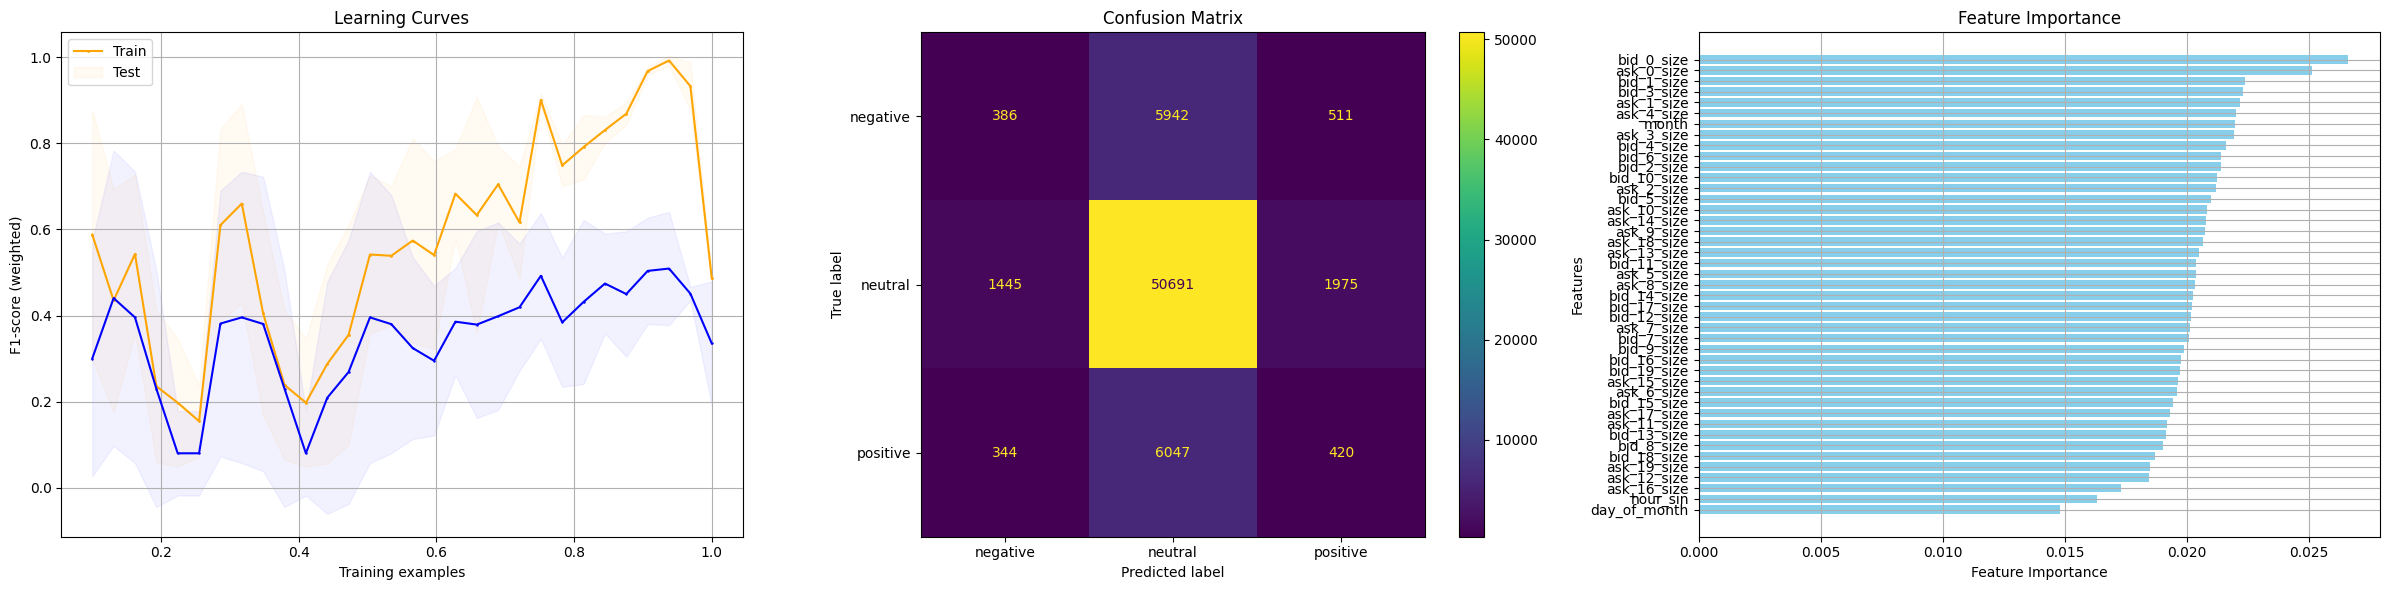

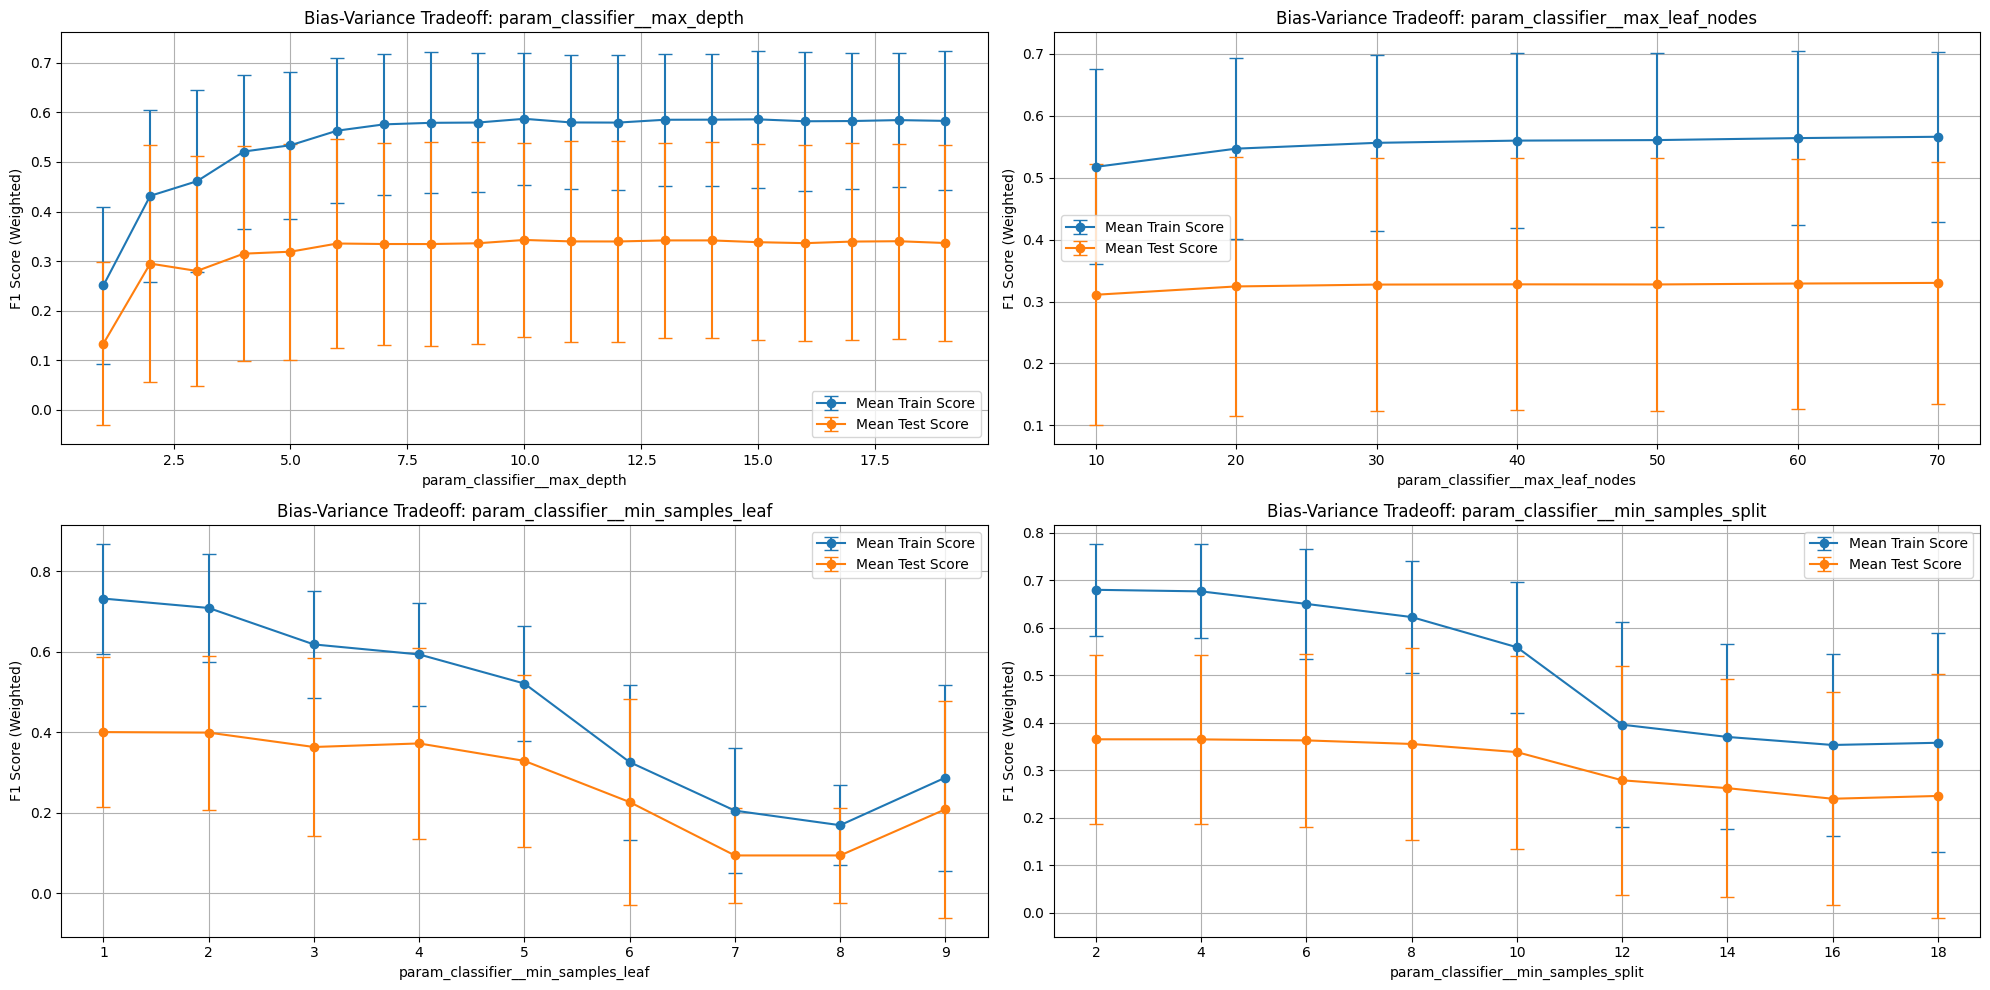


Best Decision_Tree model for HUOBI - unified
{'classifier__max_depth': 19, 'classifier__max_leaf_nodes': 60, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 4}


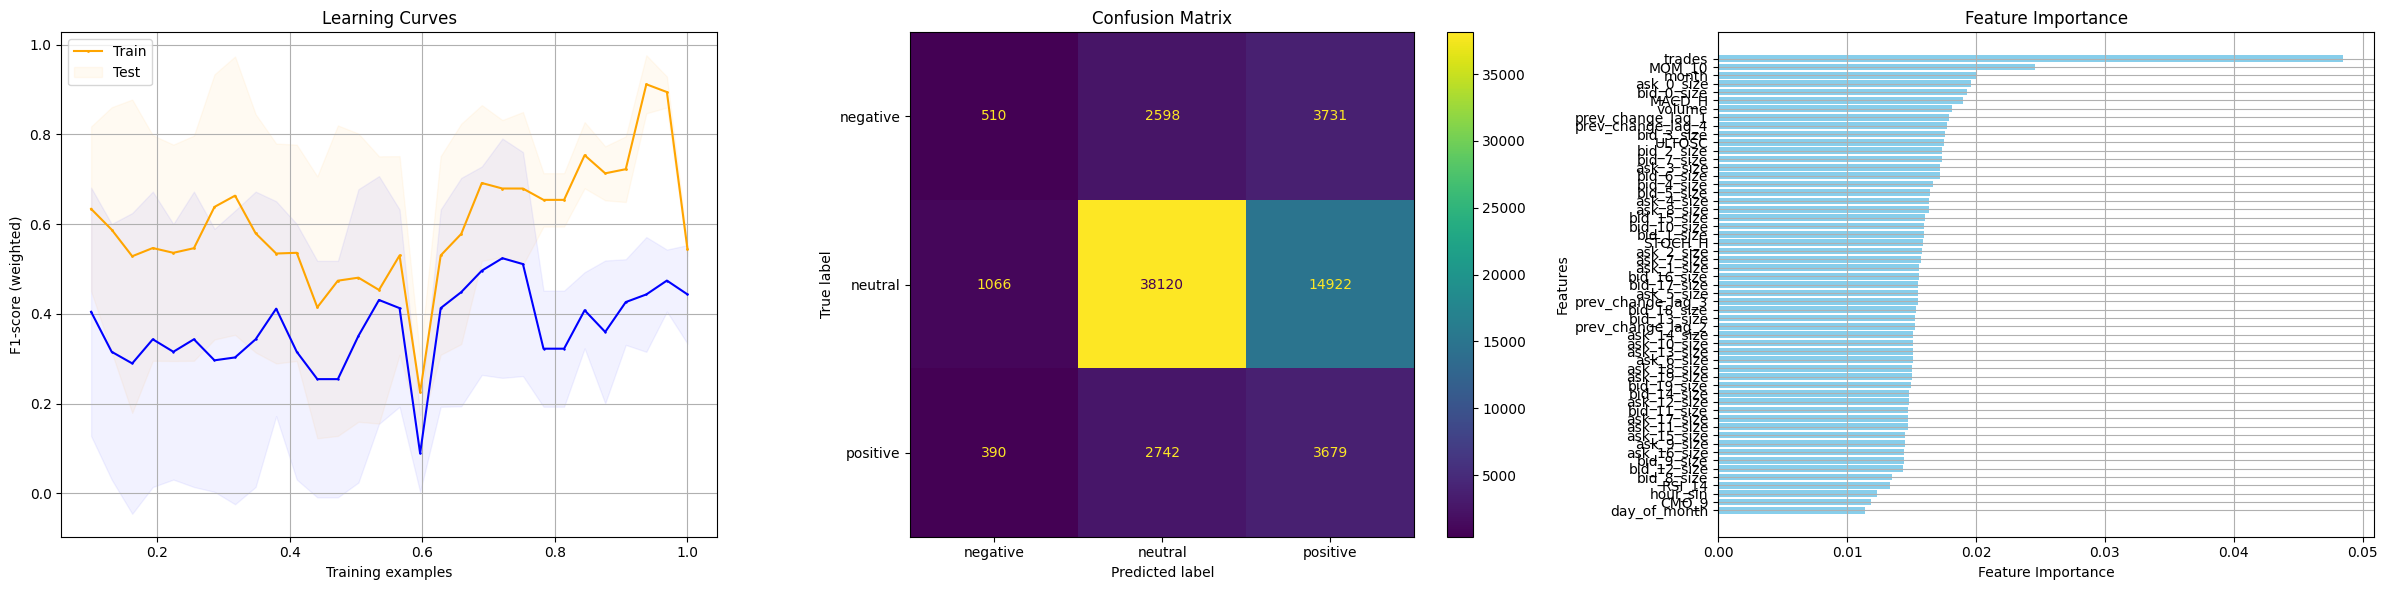

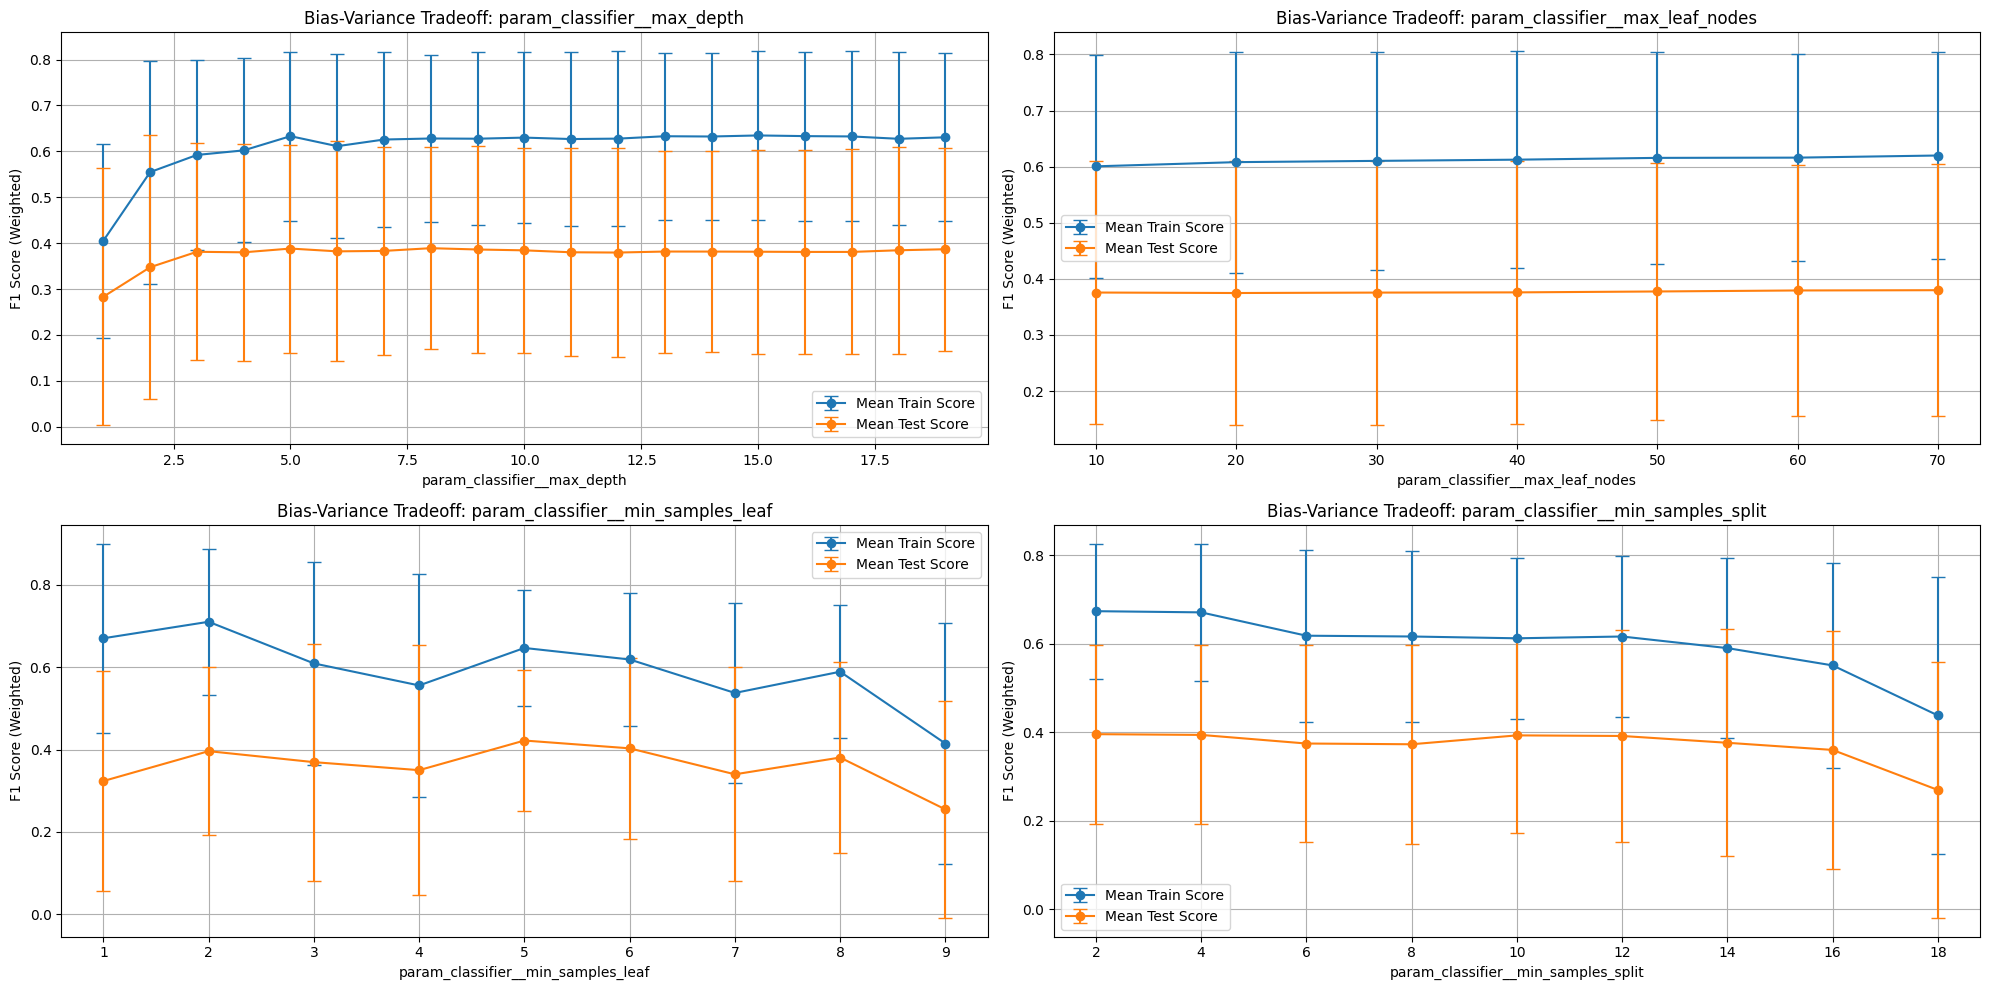


Best Decision_Tree model for OKX - candles
{'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6}


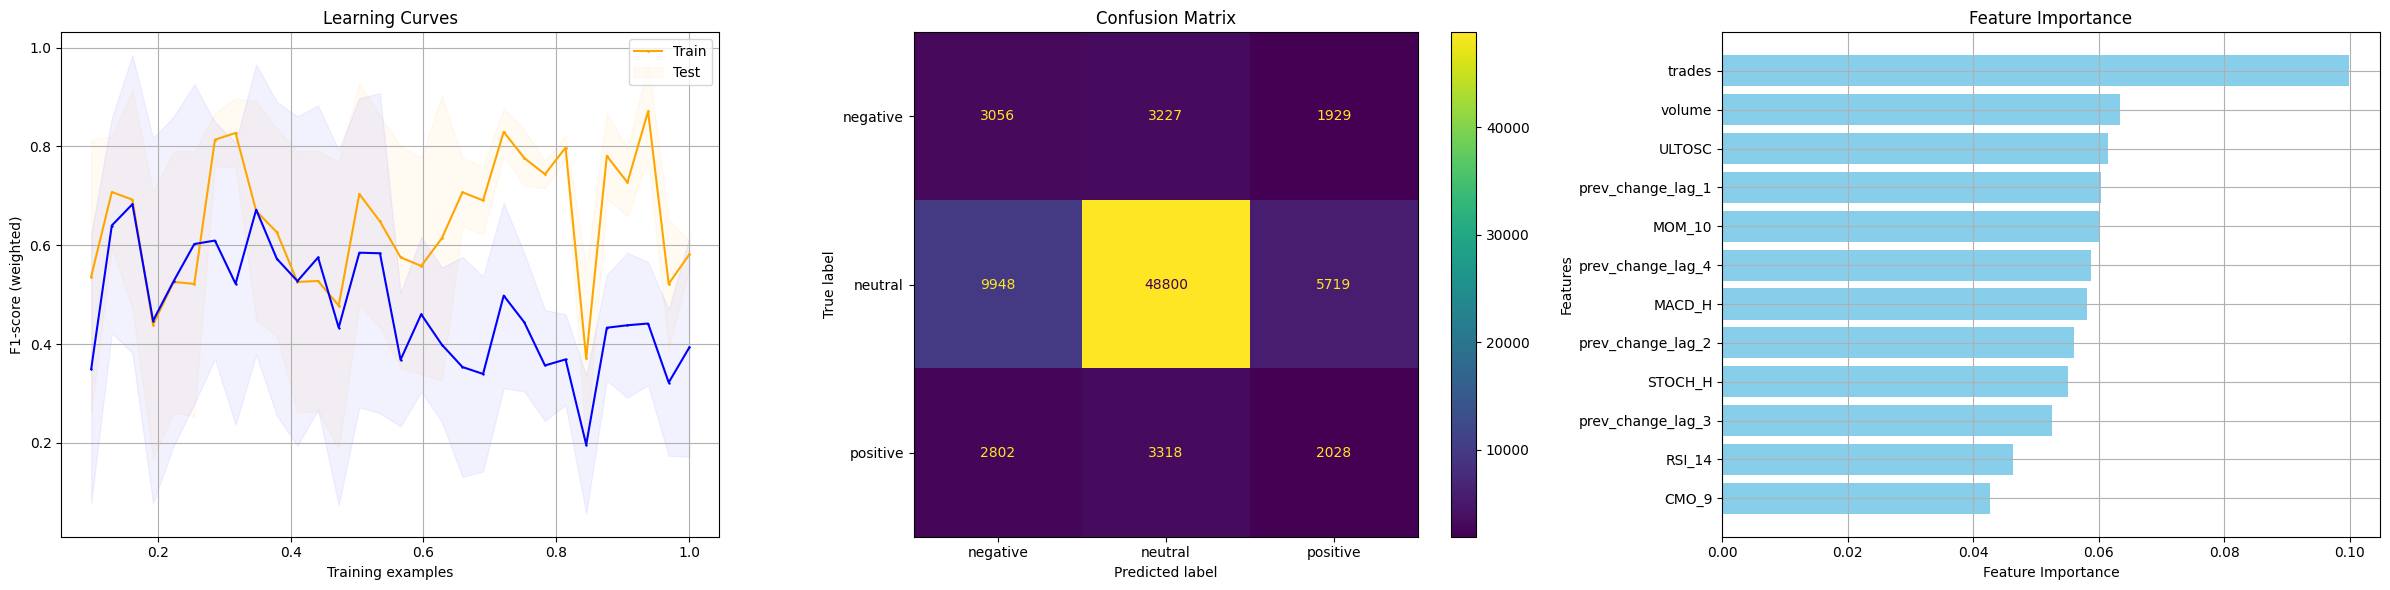

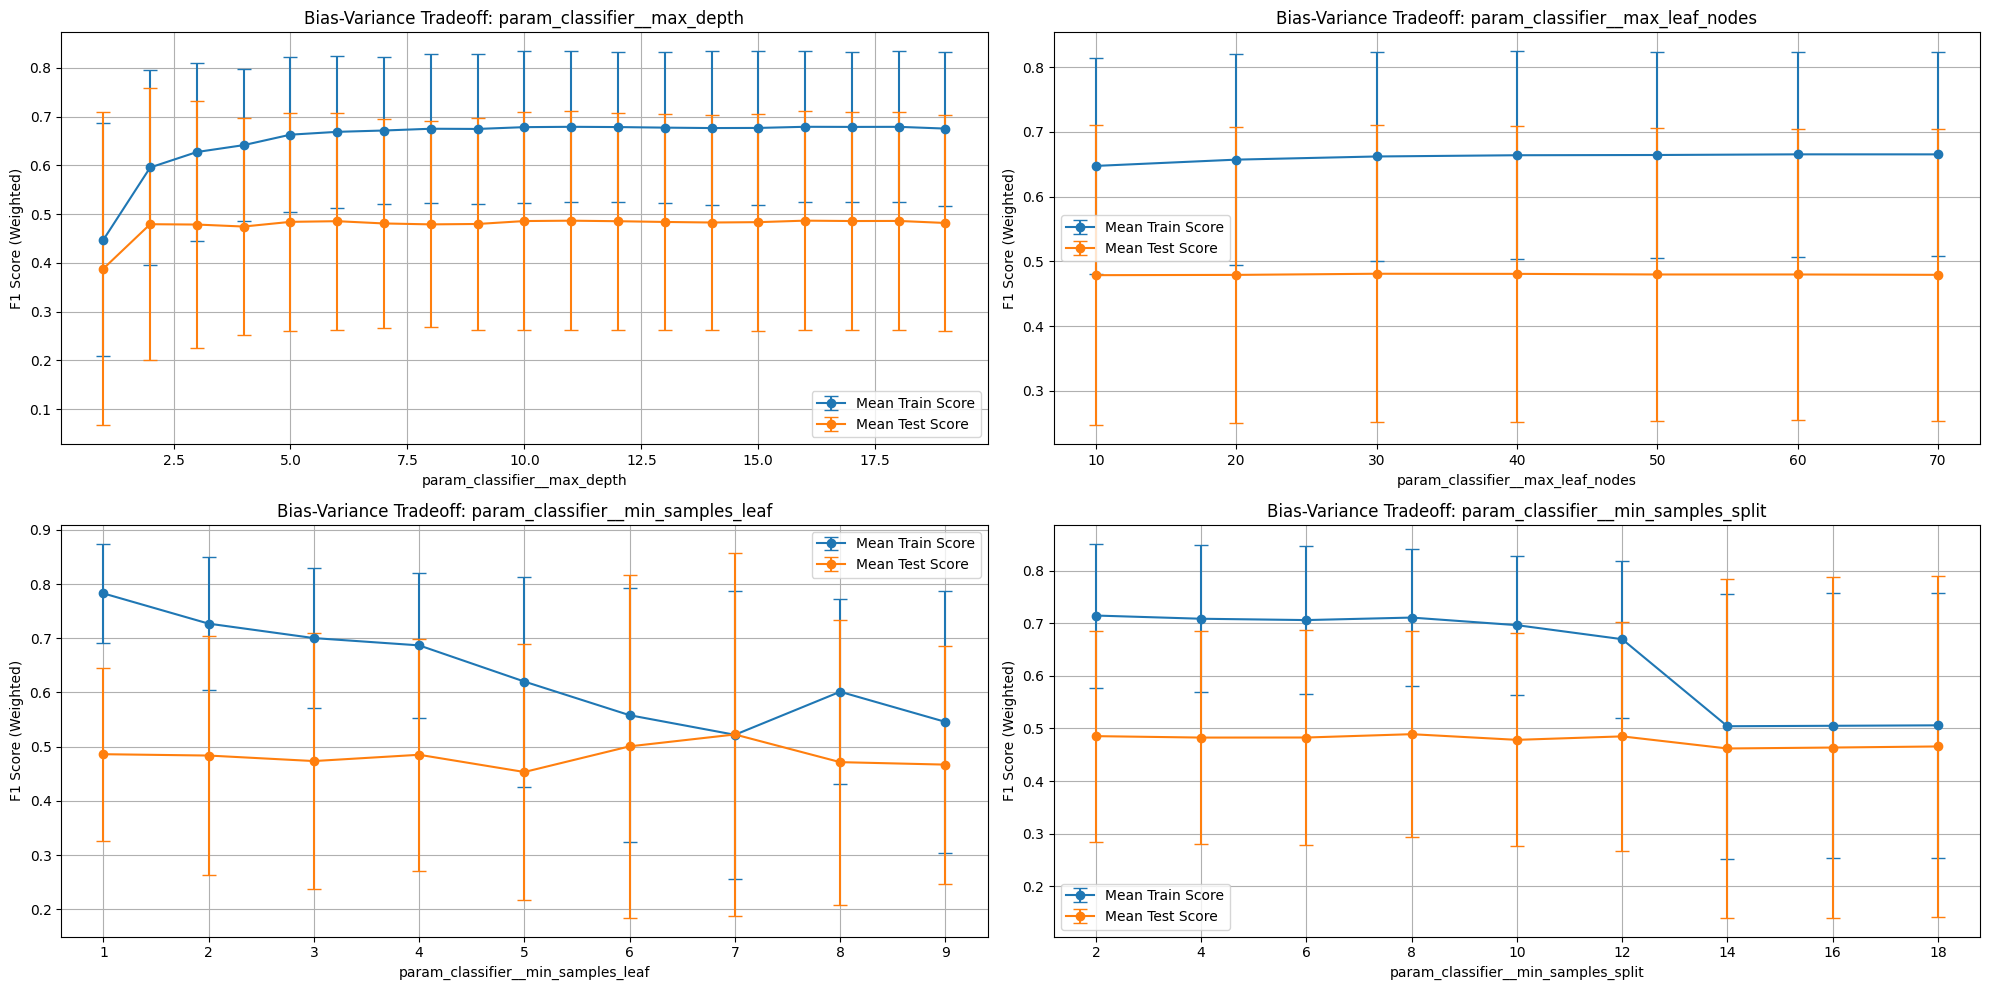


Best Decision_Tree model for OKX - orderbook
{'classifier__max_depth': 17, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


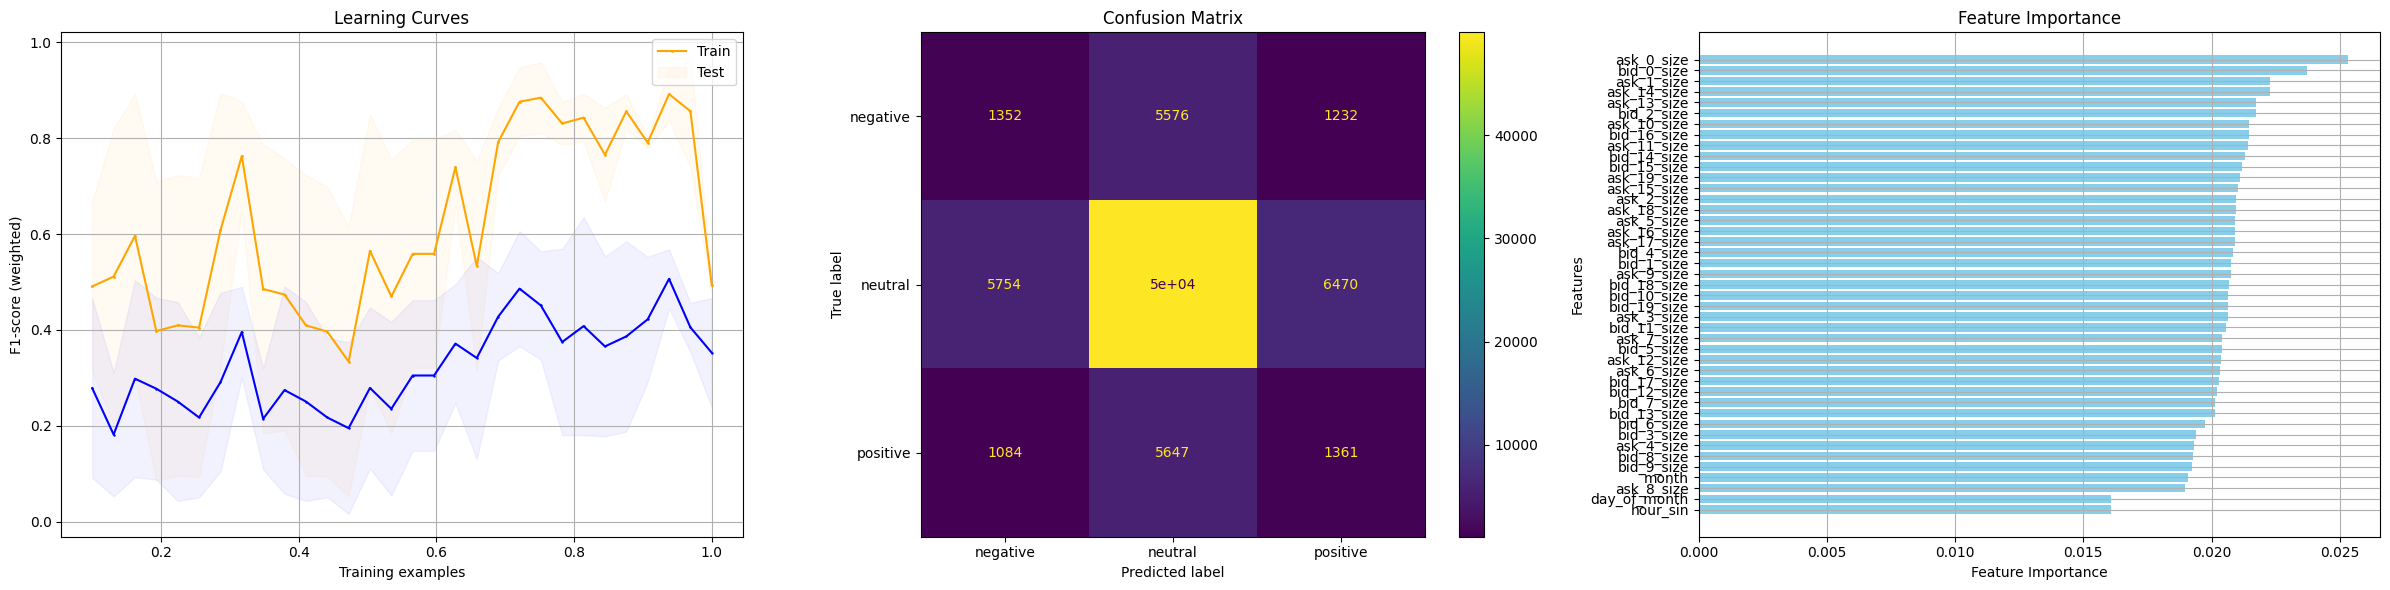

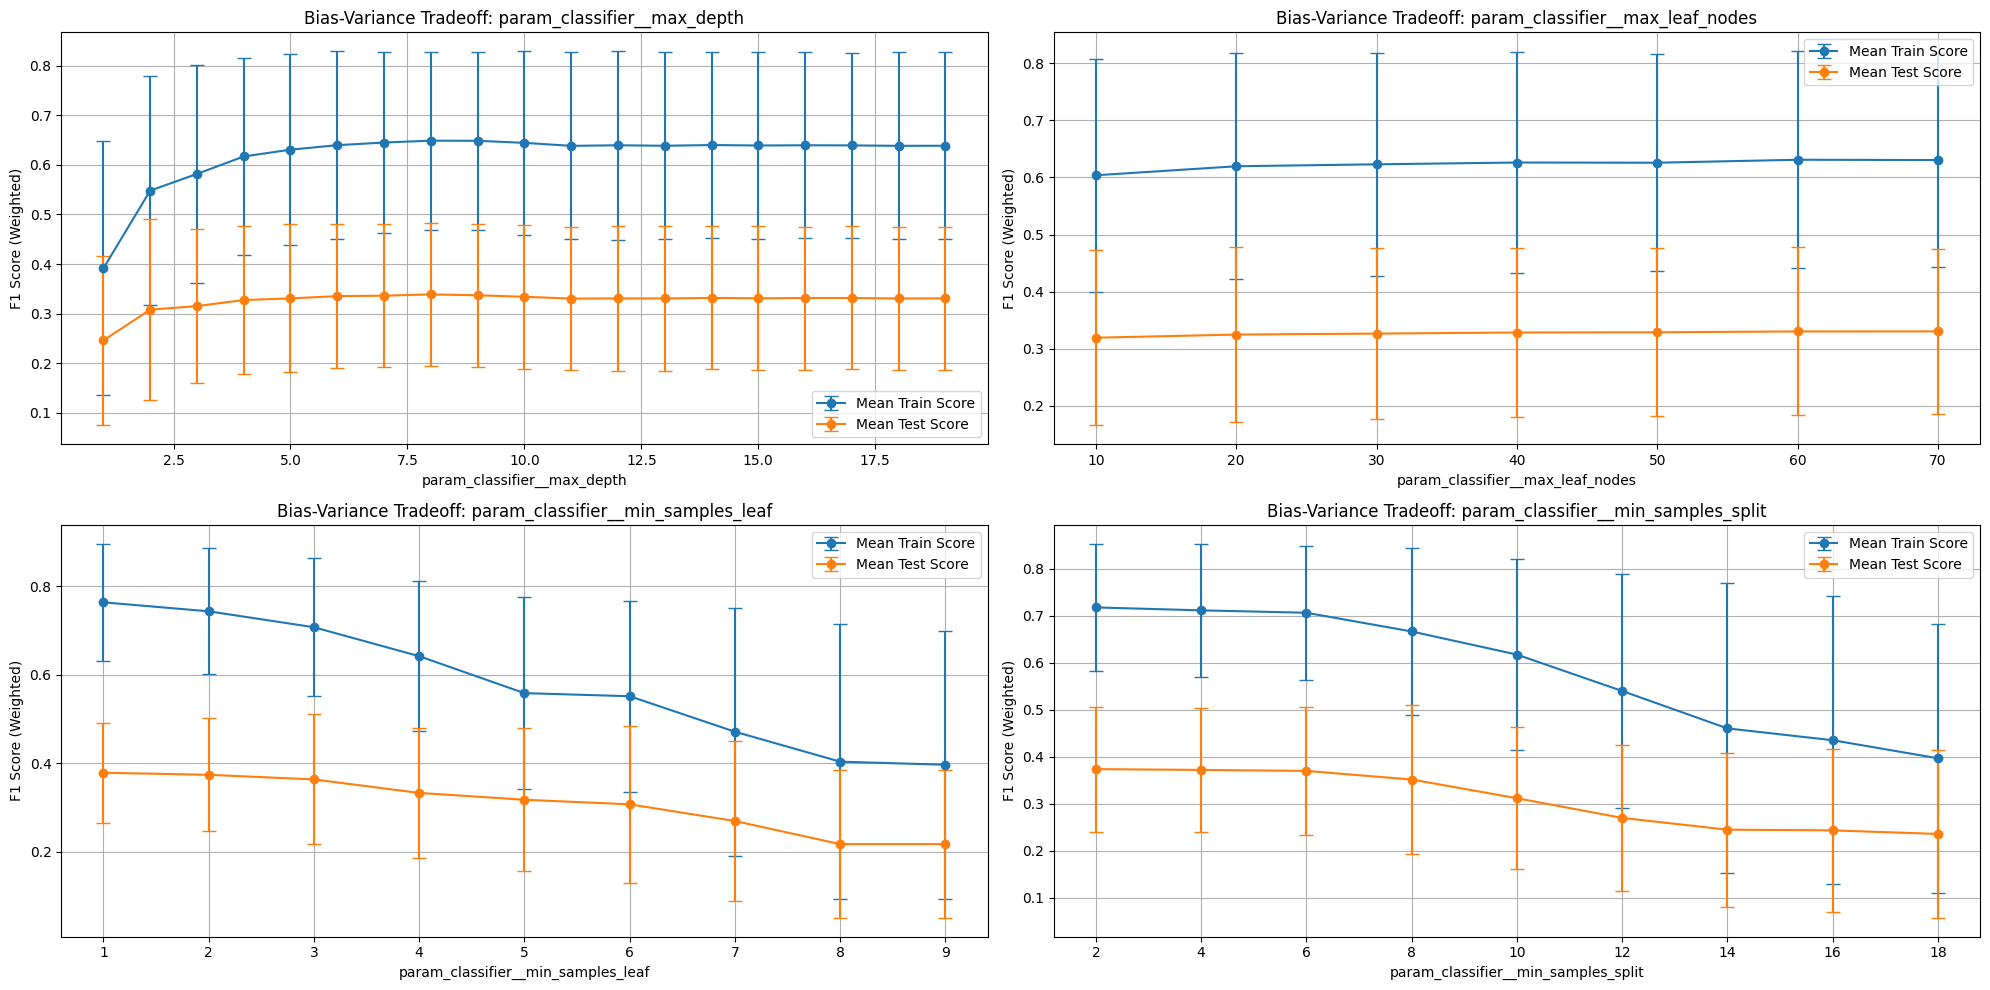


Best Decision_Tree model for OKX - unified
{'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6}


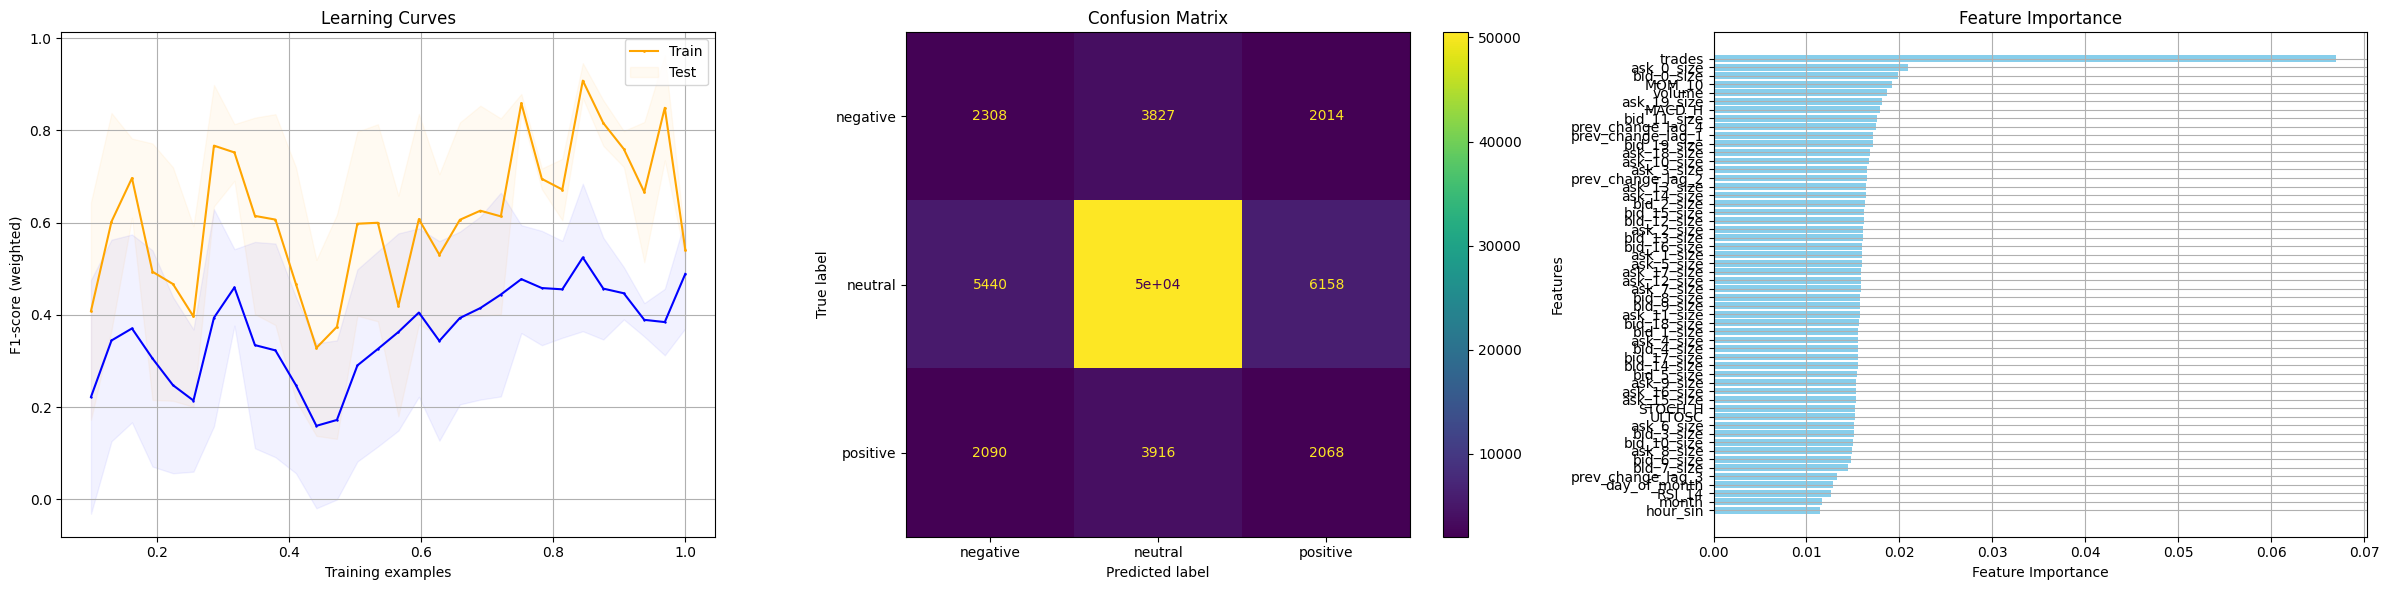

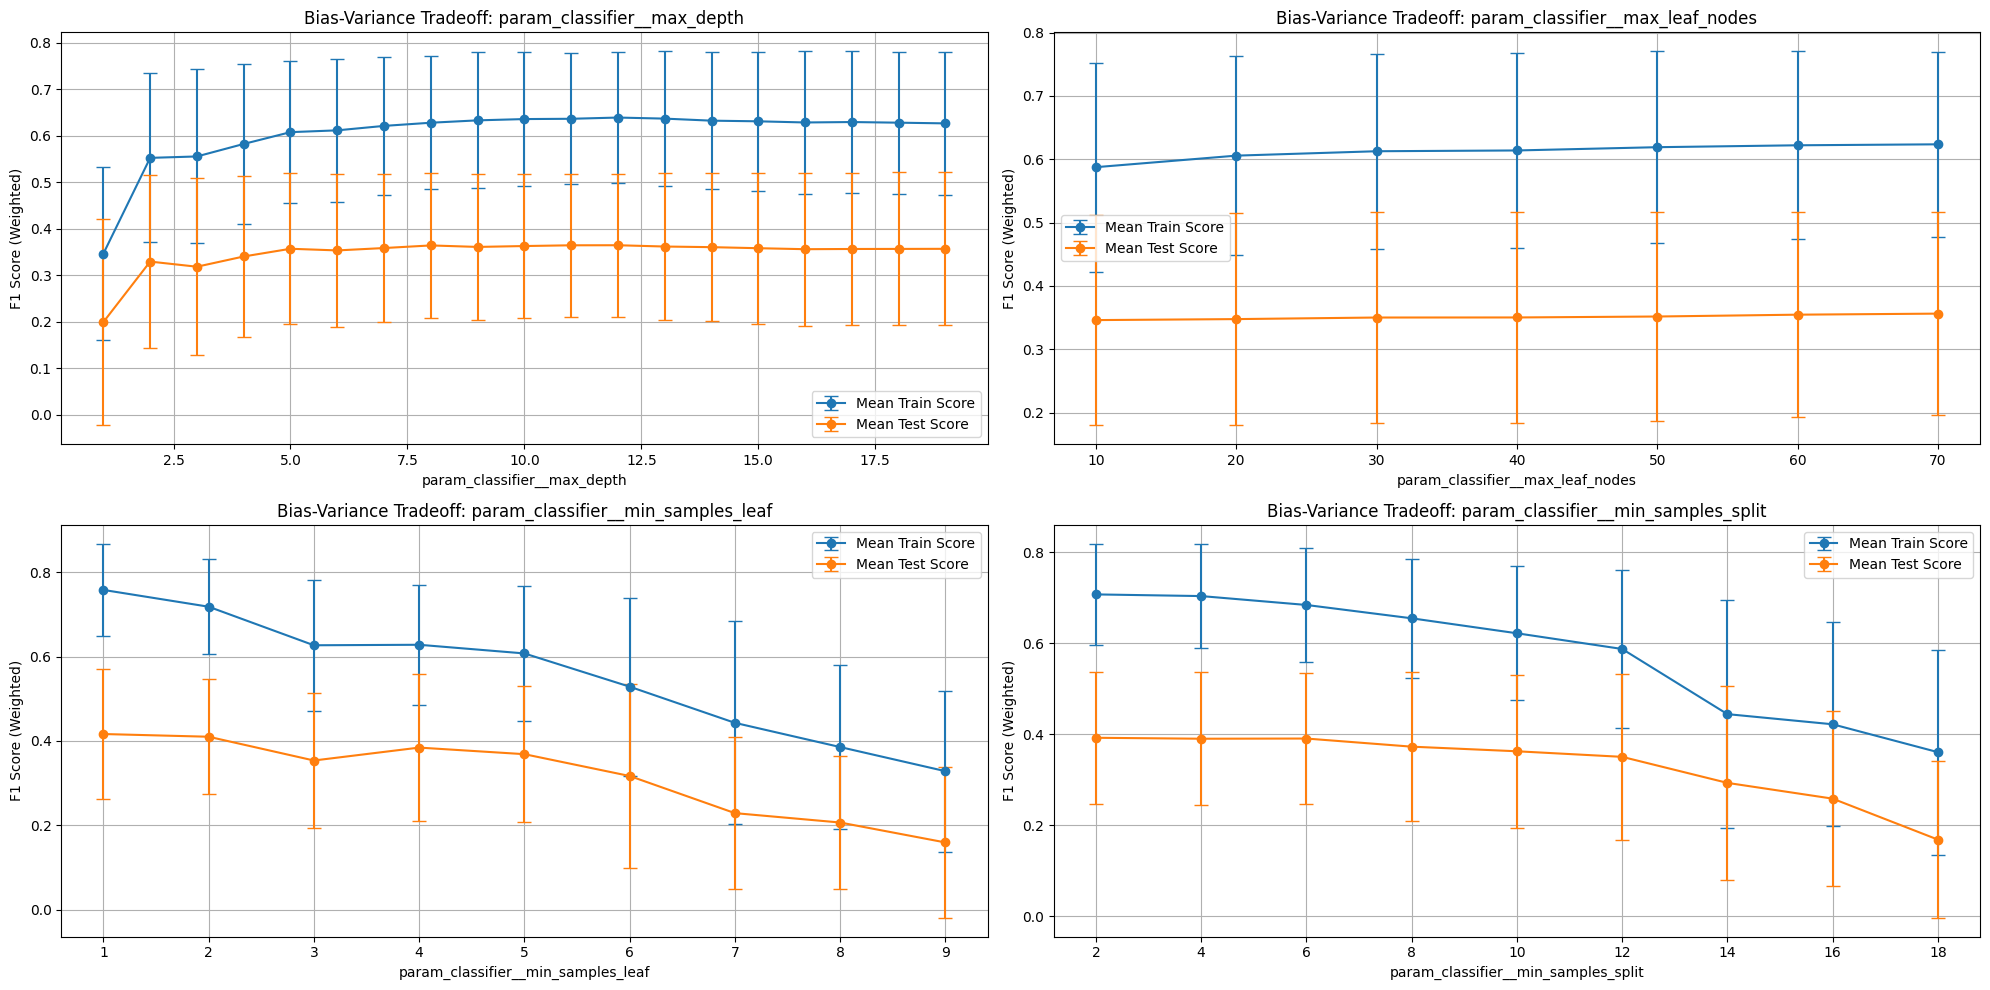


Best Decision_Tree model for ALL - unified
{'classifier__max_depth': 14, 'classifier__max_leaf_nodes': 60, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


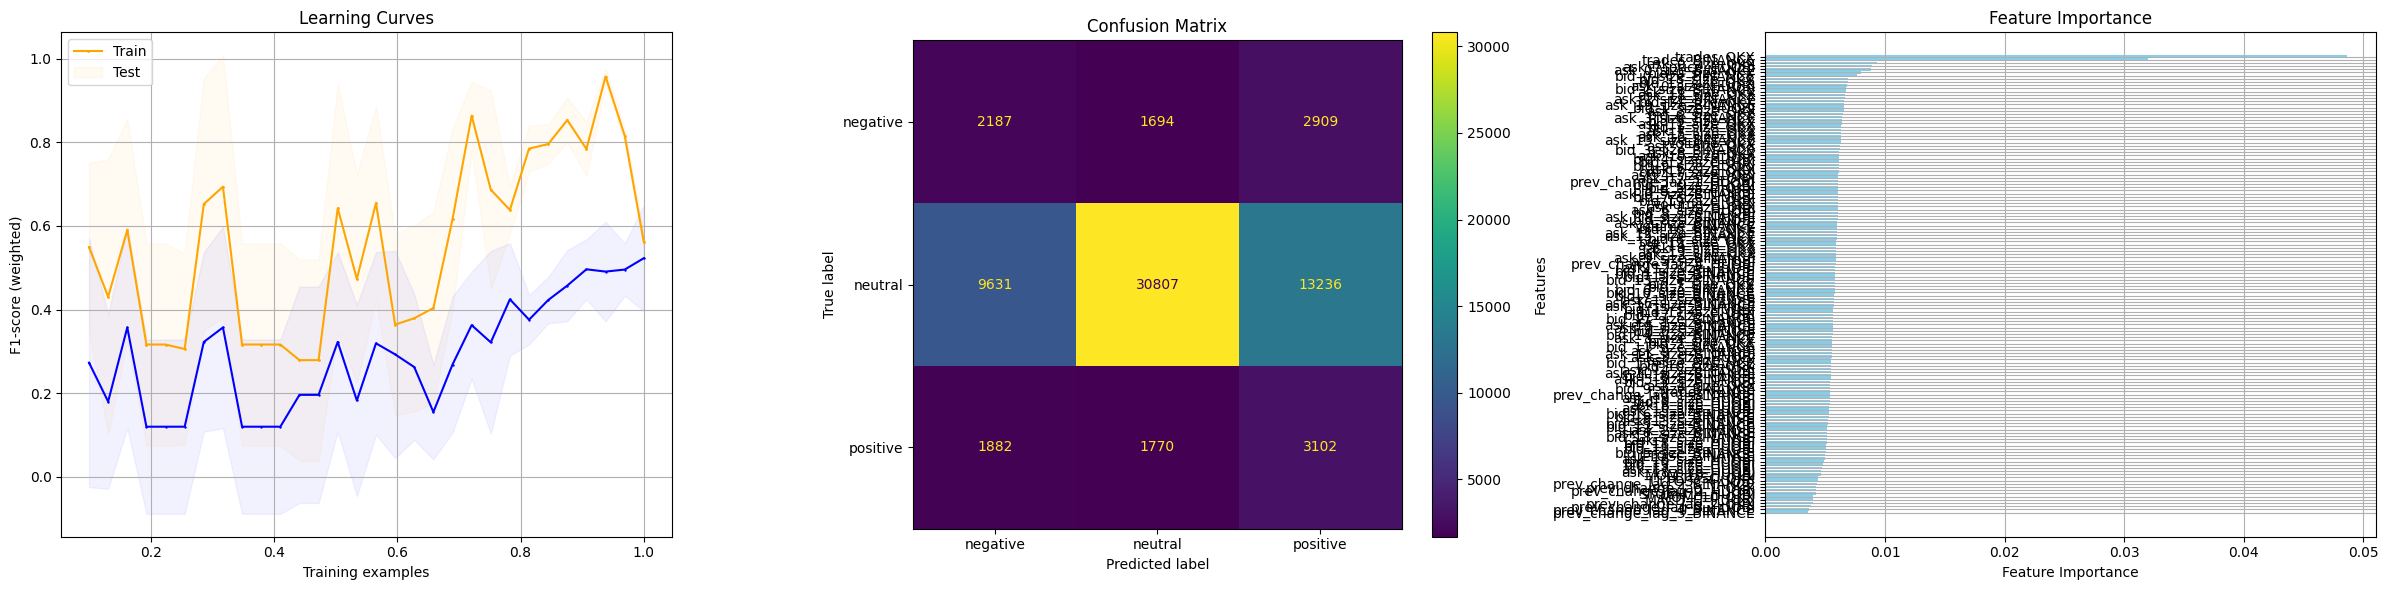

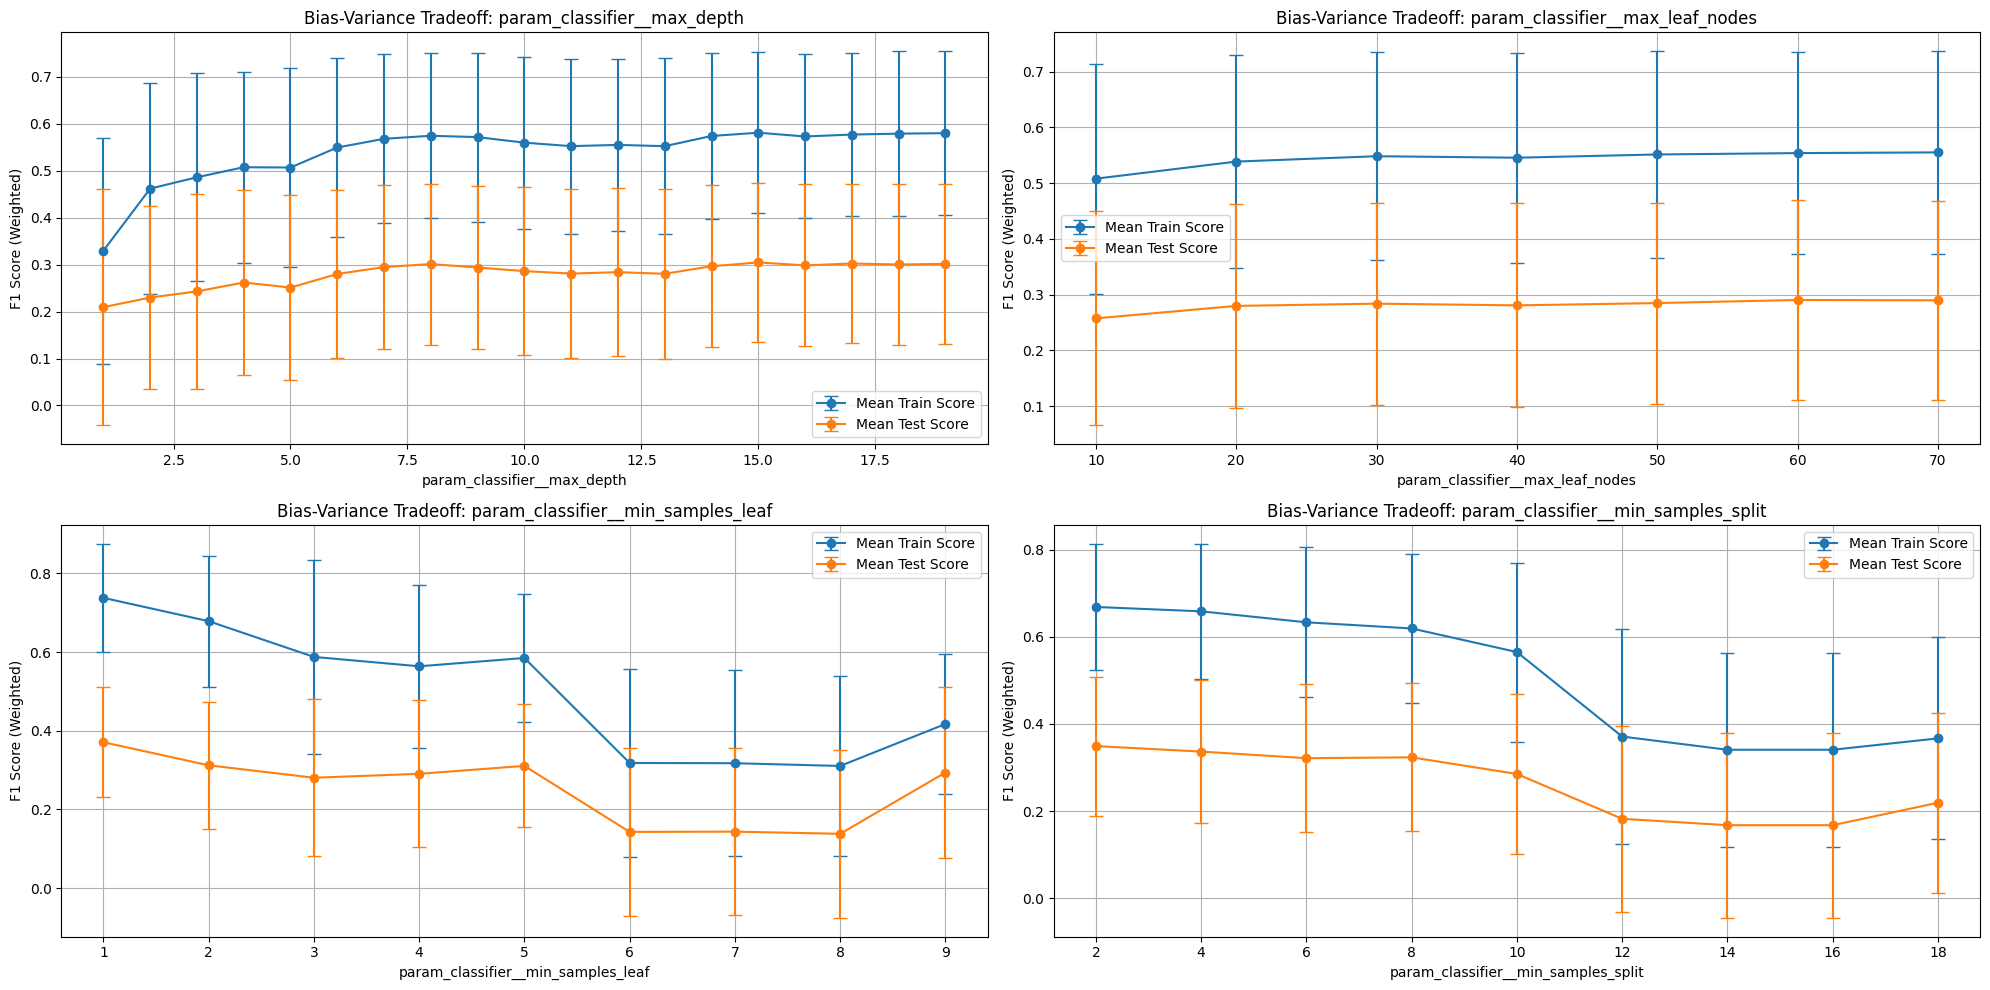


Best RFC_balanced_subsample model for BINANCE - candles
{'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 12}


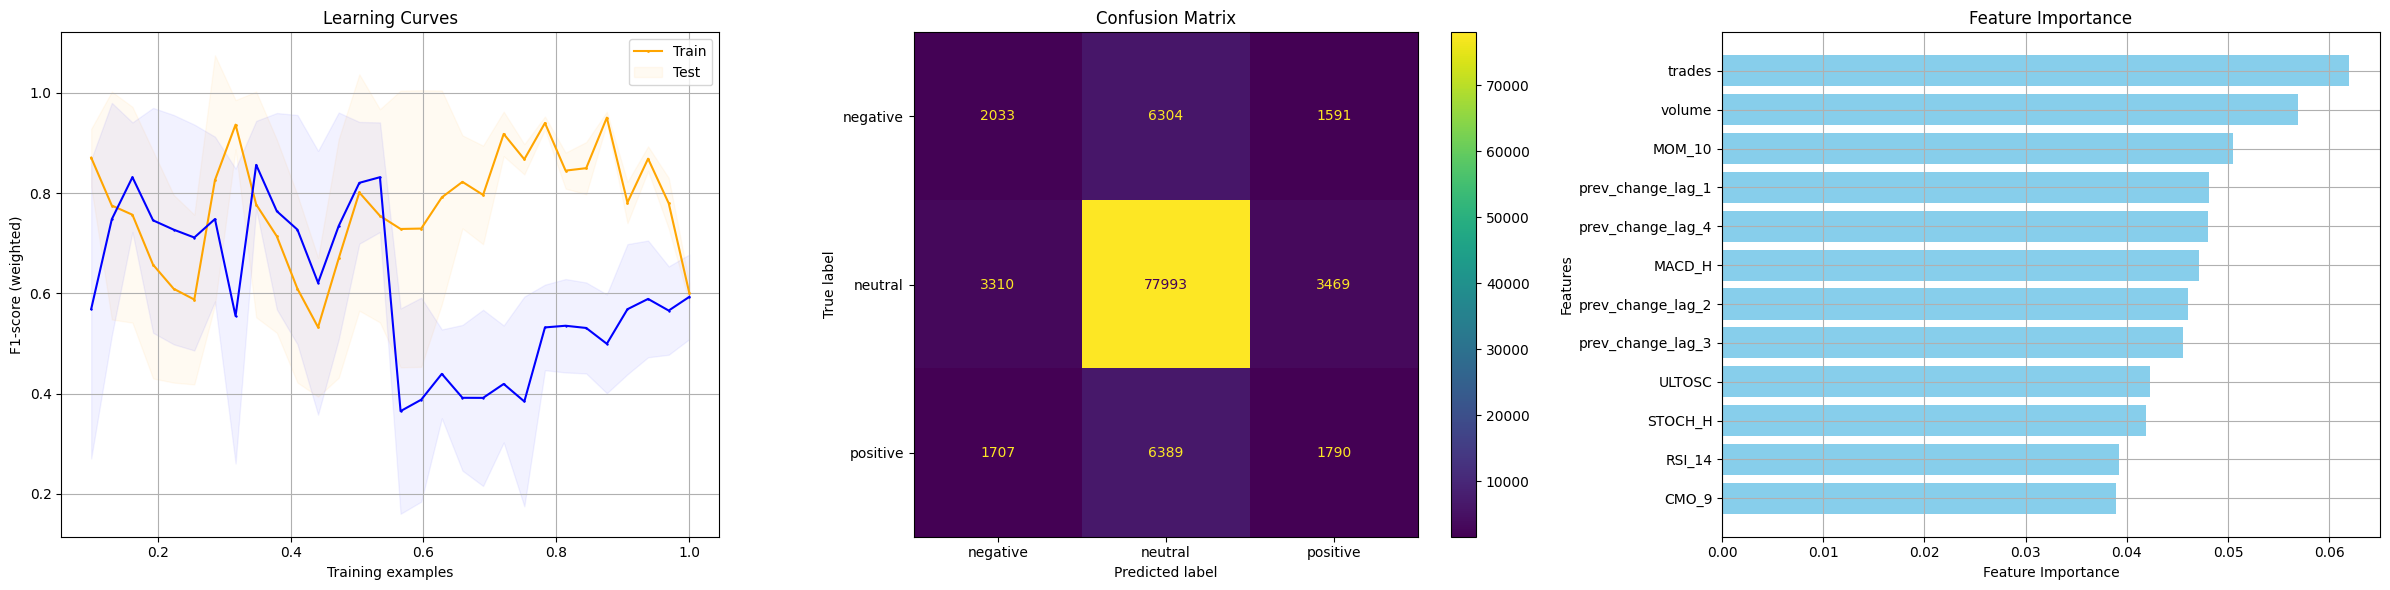

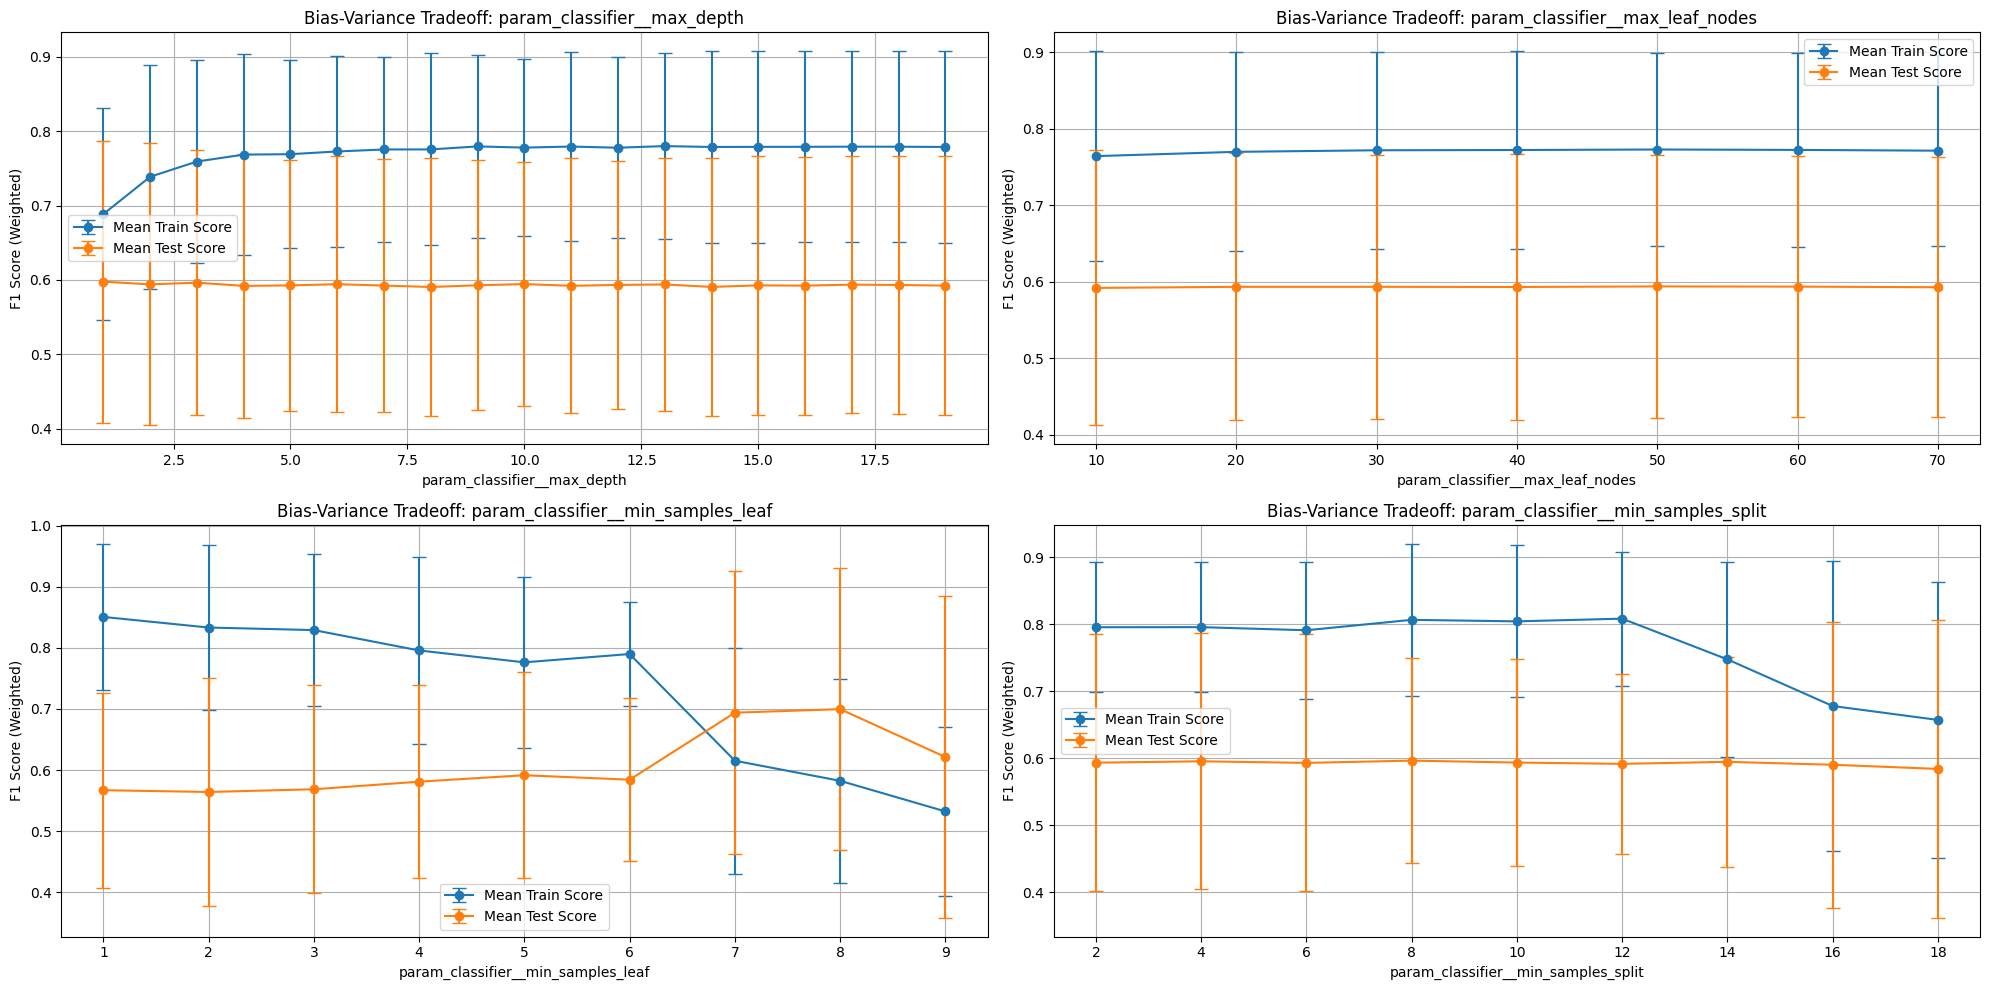


Best RFC_balanced_subsample model for BINANCE - orderbook
{'classifier__max_depth': 13, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 14}


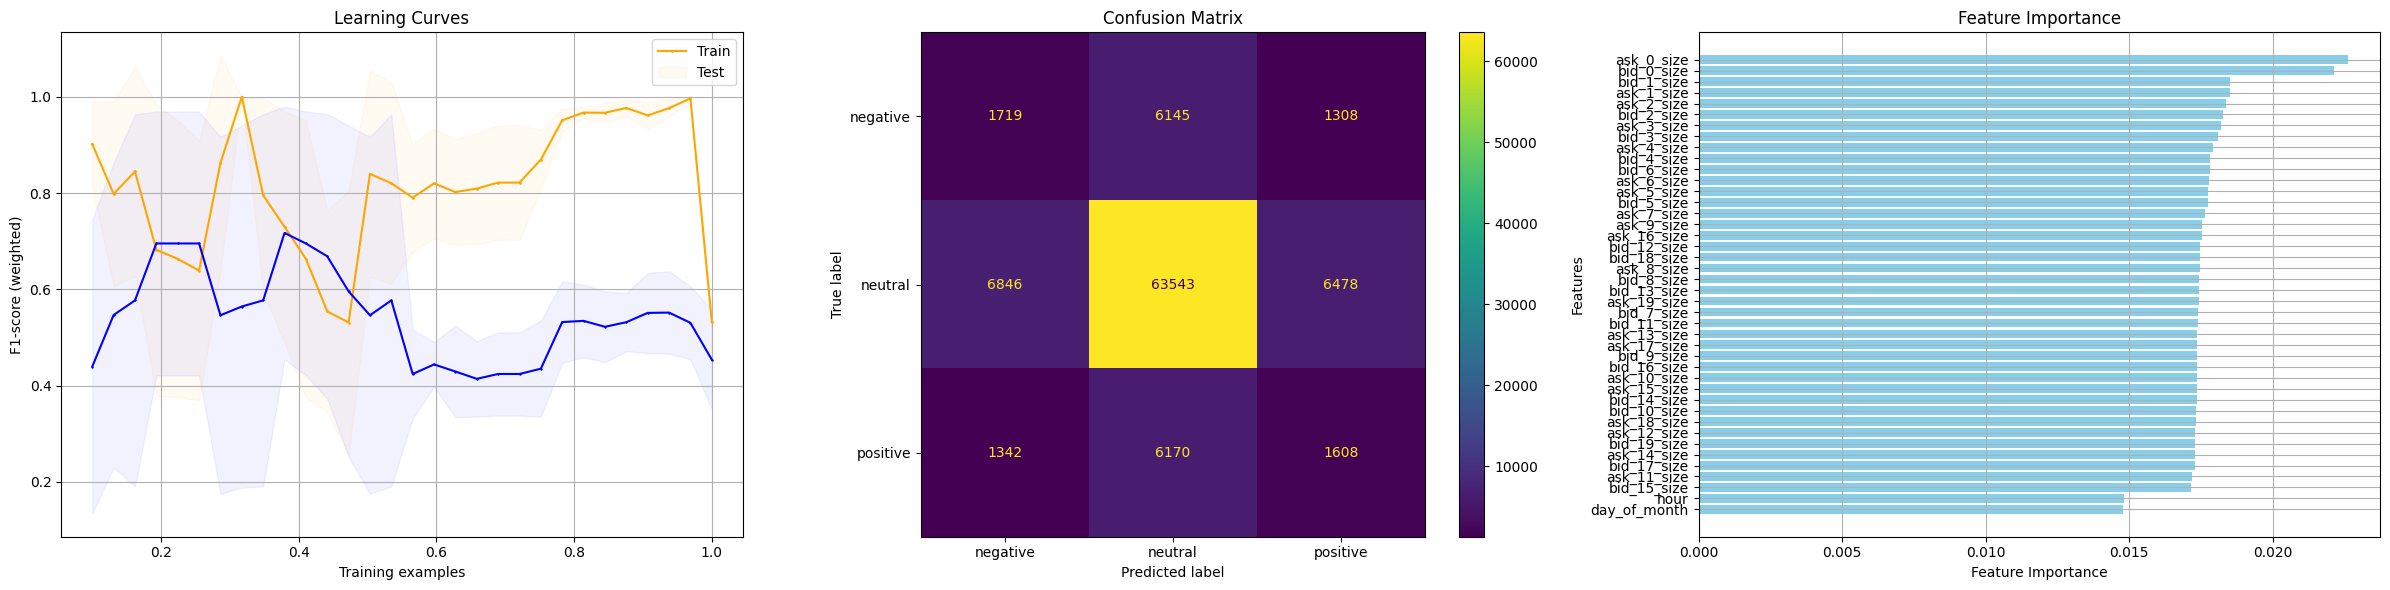

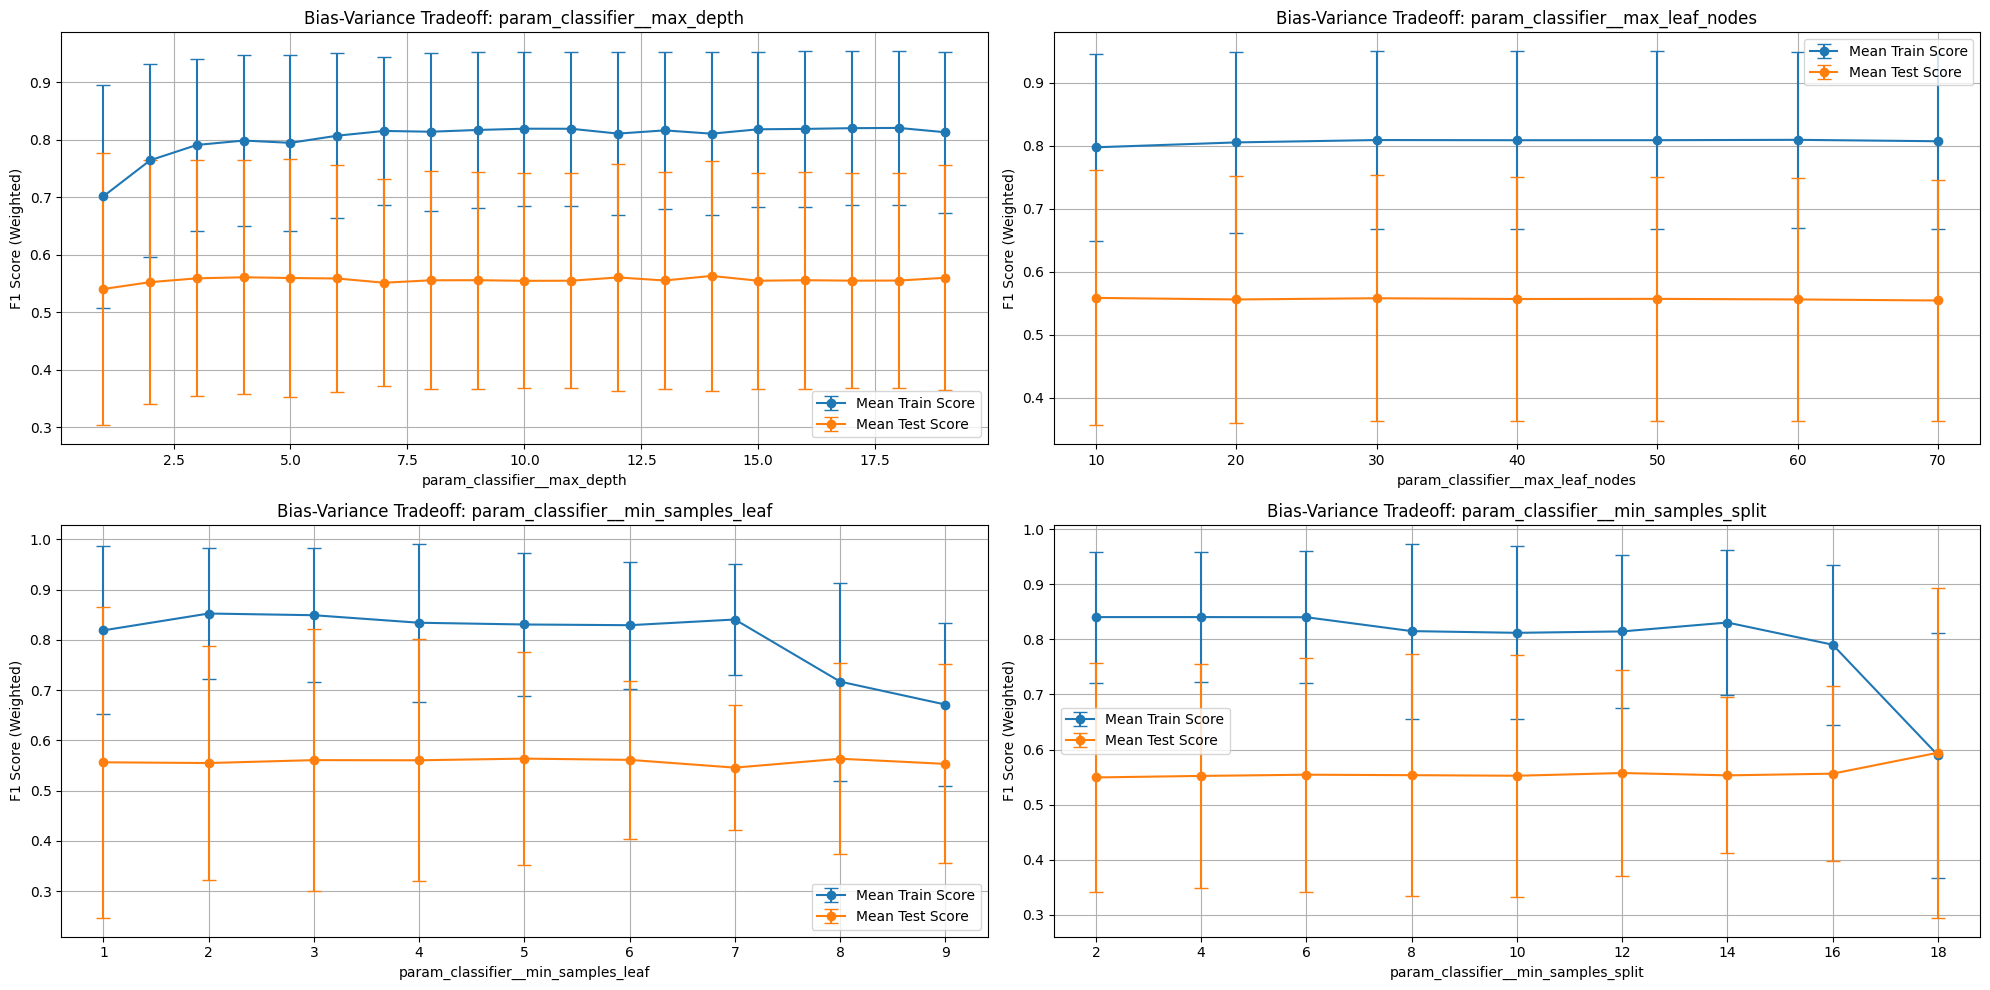


Best RFC_balanced_subsample model for BINANCE - unified
{'classifier__max_depth': 6, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4}


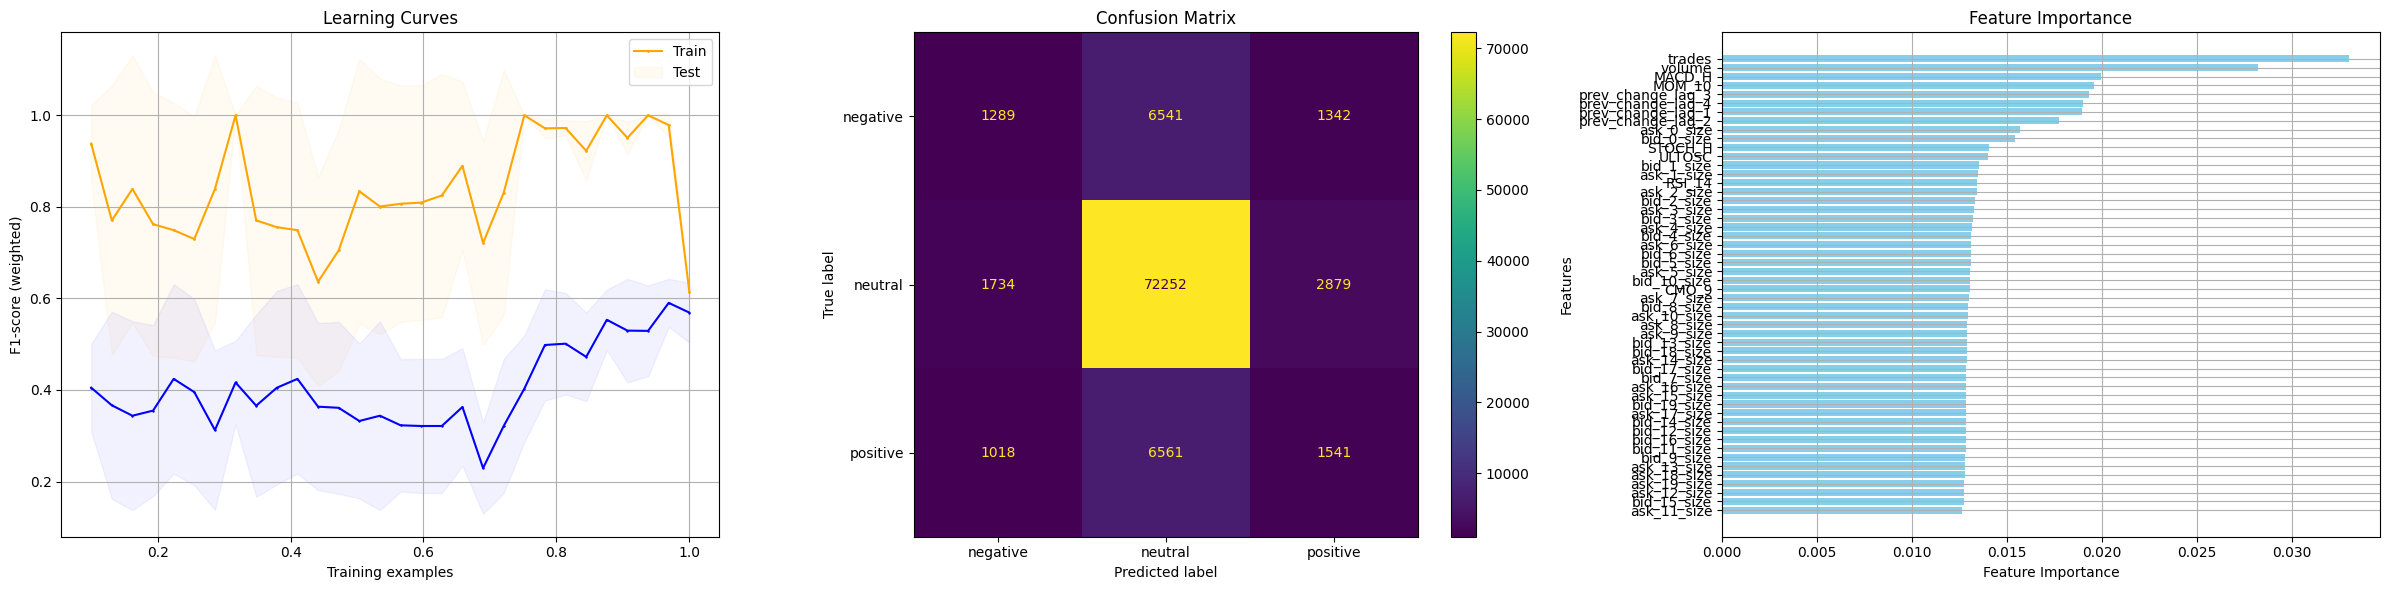

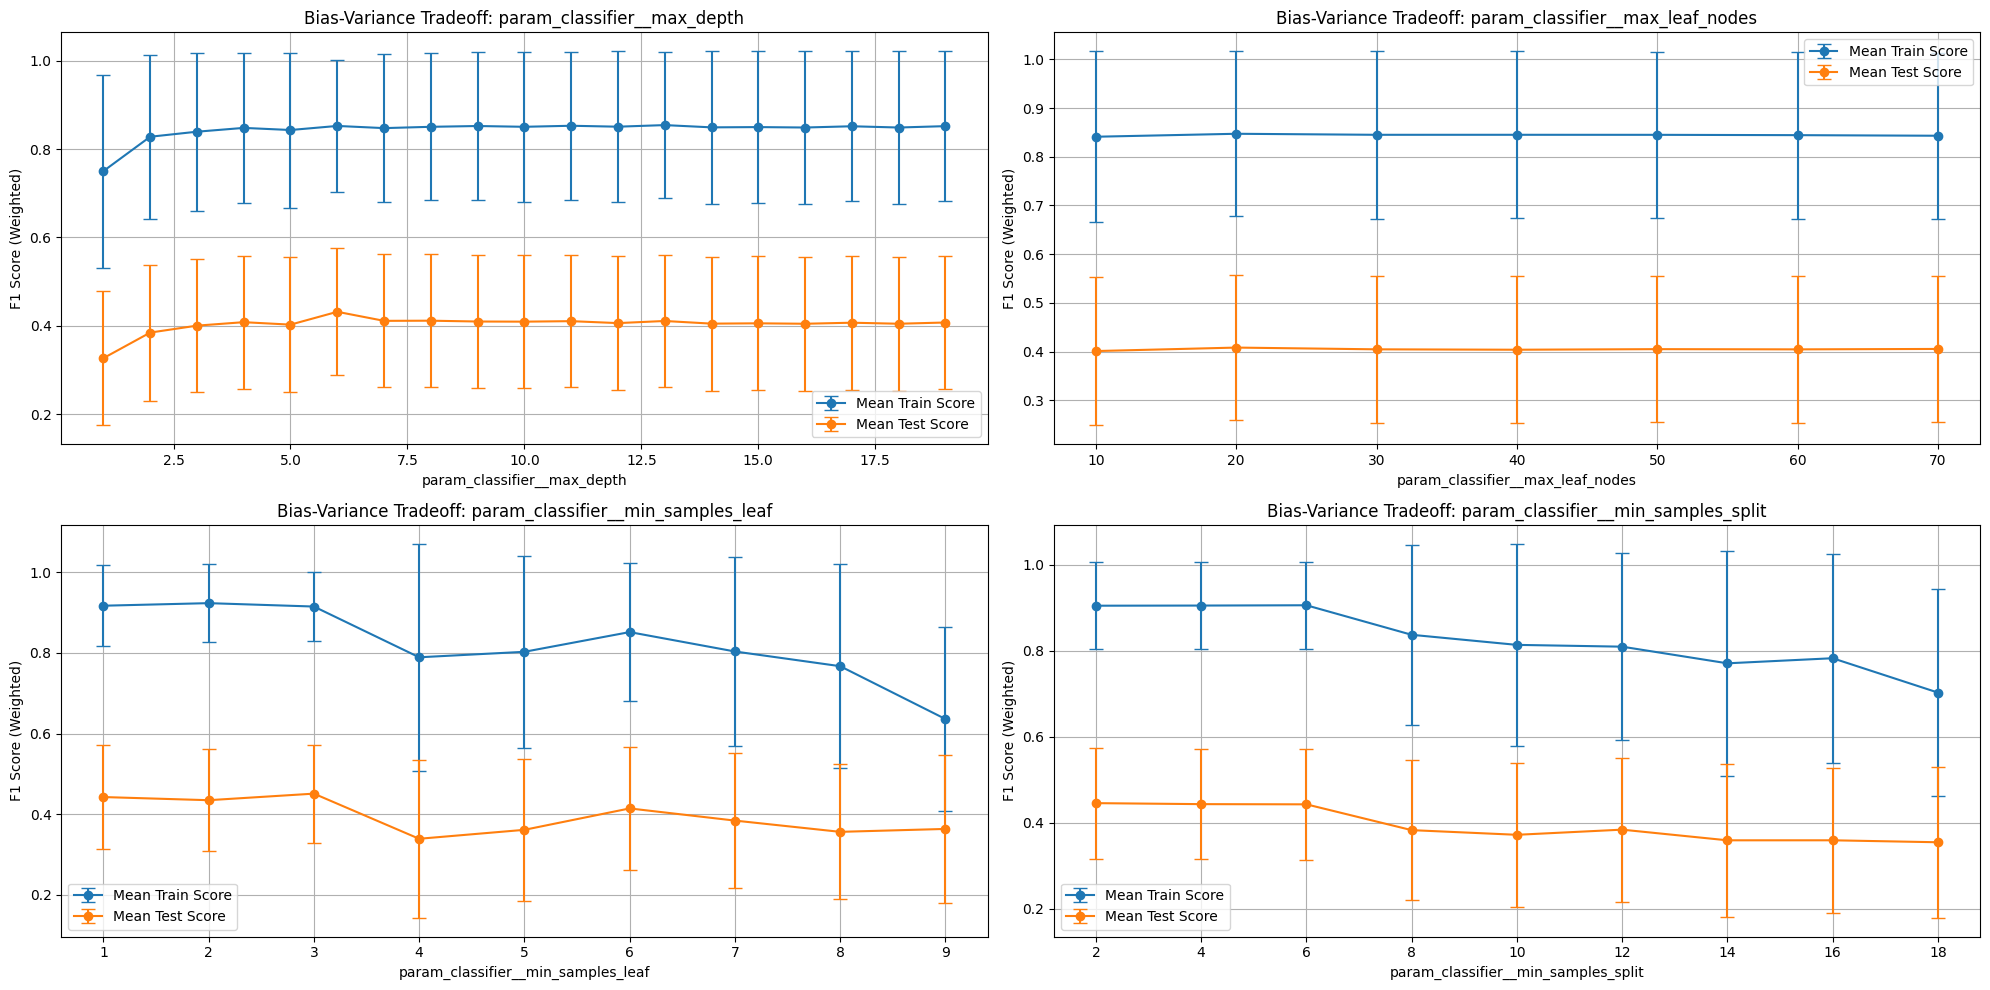

PermissionError: [Errno 13] Permission denied: 'f:\\Repository\\big_data_bitcoin_forecasting\\models\\RFC_balanced_subsample_HUOBI_candles.pkl'

In [8]:
# Evaluation

for classifier_name, _ in classifiers.items():
        for exchange, data_type in product(ALL_MODELS, DATA_TYPES):
                model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")
                
                if not os.path.exists(model_path):
                    continue

                with open(model_path, "rb") as model_file:
                    btcf = pickle.load(model_file)

                btcf.evaluate()

                save_model(btcf, classifier_name, exchange, data_type)
                
                print(f"\nBest {classifier_name} model for {exchange} - {data_type}")
                print(btcf.results['best_params'])
                
                # Plots
                filename_prefix = f"{classifier_name}_{exchange}_{data_type}"
                val_curve_param = 'classifier__max_depth'

                btcf.plot_learn_cm_feat(f"{filename_prefix}_learn_val_feat.png")
                btcf.plot_bias_variance_tradeoff(f"{filename_prefix}_bias_variance_tradeoff.png")

In [ ]:
# Results

eval_results = []
t_test_data = []
comparison_data = []
t_test_metrics = ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']

for classifier_name, _ in classifiers.items():
        for exchange, data_type in product(EXCHANGES, DATA_TYPES):
                
                model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")
                if not os.path.exists(model_path):
                    continue

                with open(model_path, "rb") as model_file:
                    btcf = pickle.load(model_file)

                eval_metrics = [x for x in btcf.results.keys() if x not in ['best_params', 'conf_matrix', 'cv_results', 'classification_report', 'feature_selection']]
                metrics_dict = {metric: btcf.results[metric] for metric in eval_metrics}
                eval_record = {
                    'classifier': classifier_name,
                    'exchange': exchange,
                    'data_type': data_type
                }
                
                eval_record.update(btcf.results['best_params'])  
                eval_record.update(metrics_dict)
                eval_results.append(eval_record)

                t_record = { metric: btcf.results['cv_results'][metric] for metric in t_test_metrics }
                t_record.update({'exchange': exchange, 'data_type': data_type, 'classifier': classifier_name })
                t_test_data.append(t_record)

                comparison_record = {**eval_record, **t_record}
                comparison_data.append(comparison_record)

results_df = pd.DataFrame(eval_results)
results_df.to_csv(os.path.join(REPORTS_PATH, 'results.csv'), index=False)
display(results_df)

data_types = results_df['data_type'].unique()
all_comparisons = pd.concat([compute_comparison(pd.DataFrame(comparison_data), data_type) for data_type in data_types], ignore_index=True)
display(all_comparisons)

ttest_results = pd.concat([perform_ttest(pd.DataFrame(t_test_data), metric) for metric in t_test_metrics], ignore_index=True)
display(ttest_results)

classifier exchange  data_type  classifier__max_depth  \
0            Decision_Tree  BINANCE    candles                      7   
1            Decision_Tree  BINANCE  orderbook                     17   
2            Decision_Tree  BINANCE    unified                     13   
3            Decision_Tree    HUOBI    candles                     11   
4            Decision_Tree    HUOBI  orderbook                     16   
5            Decision_Tree    HUOBI    unified                     19   
6            Decision_Tree      OKX    candles                      9   
7            Decision_Tree      OKX  orderbook                     17   
8            Decision_Tree      OKX    unified                      8   
9   RFC_balanced_subsample  BINANCE    candles                     10   
10  RFC_balanced_subsample  BINANCE  orderbook                     13   
11  RFC_balanced_subsample  BINANCE    unified                      6   
12  RFC_balanced_subsample    HUOBI    candles                      8   
13  RFC_balanced_subsample    HUOBI  orderbook                     19   
14  RFC_balanced_subsample    HUOBI    unified                     13   
15  RFC_balanced_subsample      OKX    candles                      9   
16  RFC_balanced_subsample      OKX  orderbook                     15   
17  RFC_balanced_subsample      OKX    unified                     19   

    classifier__max_leaf_nodes  classifier__min_samples_leaf  \
0                           70                             2   
1                           70                             4   
2                           70                             1   
3                           60                             1   
4                           70                             1   
5                           60                             5   
6                           70                             1   
7                           50                             1   
8                           70                             1   
9                           70                             6   
10                          70                             5   
11                          70                             3   
12                          70                             1   
13                          70                             4   
14                          70                             4   
15                          70                             2   
16                          70                             4   
17                          70                             2   

    classifier__min_samples_split  best_score  accuracy_balanced  \
0                               4    0.576463           0.421356   
1                               2    0.430864           0.371325   
2                               8    0.535140           0.420830   
3                               2    0.413923           0.453043   
4                               6    0.335179           0.351634   
5                               4    0.443605           0.439748   
6                               6    0.393300           0.459337   
7                               2    0.352529           0.379101   
8                               6    0.488706           0.450856   
9                              12    0.593220           0.435290   
10                             14    0.454187           0.396799   
11                              4    0.569034           0.416497   
12                              2    0.453942           0.452697   
13                             16    0.513713           0.408273   
14                             16    0.567647           0.453473   
15                              4    0.490818           0.458625   
16                             14    0.460279           0.413182   
17                             14    0.546845           0.442189   

    precision_macro  recall_macro  fscore_macro  precision_weighted  \
0          0.450853      0.421356      0.431308

data_type exchange1 exchange2  exchange1_mean_lower  exchange1_mean_upper  \
0    candles   BINANCE     HUOBI              0.521059              0.523521   
1    candles   BINANCE       OKX              0.521040              0.523627   
2    candles     HUOBI       OKX              0.455626              0.457128   
3  orderbook   BINANCE     HUOBI              0.461824              0.464091   
4  orderbook   BINANCE       OKX              0.461822              0.464181   
5  orderbook     HUOBI       OKX              0.421688              0.424257   
6    unified   BINANCE     HUOBI              0.381329              0.383091   
7    unified   BINANCE       OKX              0.381371              0.383029   
8    unified     HUOBI       OKX              0.428092              0.430488   

   exchange2_mean_lower  exchange2_mean_upper  mean_diff_lower  \
0              0.455715              0.457184         0.064367   
1              0.489836              0.491784         0.029978   
2              0.489756              0.491782        -0.035575   
3              0.421733              0.424171         0.038226   
4              0.377769              0.379517         0.082794   
5              0.377731              0.379444         0.042823   
6              0.428126              0.430587        -0.048610   
7              0.416596              0.418617        -0.036755   
8              0.416602              0.418661         0.009996   

   mean_diff_upper  exchange1_ci_percentage  exchange2_ci_percentage  \
0         0.067281                 0.472530                 0.322401   
1         0.033195                 0.496509                 0.397567   
2        -0.033218                 0.329709                 0.413685   
3         0.041700                 0.491019                 0.578166   
4         0.085876                 0.510829                 0.462658   
5         0.045872                 0.609343                 0.453679   
6        -0.045616                 0.462152                 0.574815   
7        -0.034136                 0.434840                 0.485176   
8         0.013357                 0.559914                 0.494286   

   mean_diff_ci_percentage  
0                 4.526601  
1                10.730227  
2                 6.626063  
3                 9.087987  
4                 3.721914  
5                 7.120644  
6                 6.158657  
7                 7.124173  
8                33.626081

data_type exchange1 exchange2            metric     t_stat        p_value
0     candles   BINANCE     HUOBI   mean_test_score  51.137221   0.000000e+00
1     candles   BINANCE       OKX   mean_test_score -36.442486  1.574090e-285
2     candles     HUOBI       OKX   mean_test_score -73.535570   0.000000e+00
3   orderbook   BINANCE     HUOBI   mean_test_score  46.463430   0.000000e+00
4   orderbook   BINANCE       OKX   mean_test_score  54.247097   0.000000e+00
5   orderbook     HUOBI       OKX   mean_test_score  -1.508220   1.315061e-01
6     unified   BINANCE     HUOBI   mean_test_score -20.439792   2.037476e-92
7     unified   BINANCE       OKX   mean_test_score   9.166829   5.084404e-20
8     unified     HUOBI       OKX   mean_test_score  28.107971  3.192992e-172
9     candles   BINANCE     HUOBI  mean_train_score -21.138008   1.129437e-98
10    candles   BINANCE       OKX  mean_train_score   4.718114   2.387878e-06
11    candles     HUOBI       OKX  mean_train_score  25.541627  7.918166e-143
12  orderbook   BINANCE     HUOBI  mean_train_score  38.603643   0.000000e+00
13  orderbook   BINANCE       OKX  mean_train_score   4.833819   1.344195e-06
14  orderbook     HUOBI       OKX  mean_train_score -32.188542  1.741399e-224
15    unified   BINANCE     HUOBI  mean_train_score  13.119487   3.069705e-39
16    unified   BINANCE       OKX  mean_train_score  11.306633   1.339387e-29
17    unified     HUOBI       OKX  mean_train_score  -0.304464   7.607763e-01
18    candles   BINANCE     HUOBI    std_test_score -17.452964   5.641726e-68
19    candles   BINANCE       OKX    std_test_score -48.760394   0.000000e+00
20    candles     HUOBI       OKX    std_test_score -31.913666  8.187463e-221
21  orderbook   BINANCE     HUOBI    std_test_score -27.137273  1.251242e-160
22  orderbook   BINANCE       OKX    std_test_score  67.780807   0.000000e+00
23  orderbook     HUOBI       OKX    std_test_score  80.242467   0.000000e+00
24    unified   BINANCE     HUOBI    std_test_score -52.634802   0.000000e+00
25    unified   BINANCE       OKX    std_test_score  50.861854   0.000000e+00
26    unified     HUOBI       OKX    std_test_score  94.551978   0.000000e+00
27    candles   BINANCE     HUOBI   std_train_score -17.456430   5.348855e-68
28    candles   BINANCE       OKX   std_train_score  -7.449767   9.526235e-14
29    candles     HUOBI       OKX   std_train_score  10.223054   1.668071e-24
30  orderbook   BINANCE     HUOBI   std_train_score  45.896507   0.000000e+00
31  orderbook   BINANCE       OKX   std_train_score  -9.824469   9.342206e-23
32  orderbook     HUOBI       OKX   std_train_score -52.936190   0.000000e+00
33    unified   BINANCE     HUOBI   std_train_score  -7.177317   7.224068e-13
34    unified   BINANCE       OKX   std_train_score  33.855642  8.257996e-248
35    unified     HUOBI       OKX   std_train_score  43.001880   0.000000e+00

In [ ]:
# Aggregated results

aggregated_eval_results = []

for classifier_name, _ in classifiers.items():
  for exchange, data_type in product(ALL_MODELS, DATA_TYPES):
    model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")

    if not os.path.exists(model_path):
      continue

    with open(model_path, "rb") as model_file:
      btcf = pickle.load(model_file)

    aggregated_eval_results.append({
      "classifier": classifier_name,
      "exchange": exchange,
      "data_type": data_type,
      "train_score_mean": btcf.results['cv_results']['mean_train_score'],
      "std_train_score": btcf.results['cv_results']['std_train_score'],
      "test_score_mean": btcf.results['cv_results']['mean_test_score'],
      "std_test_score": btcf.results['cv_results']['std_test_score']
    })

aggregated_eval_results = pd.DataFrame(aggregated_eval_results)


In [19]:
display(aggregated_eval_results)

classifier exchange  data_type  \
0            Decision_Tree  BINANCE    candles   
1            Decision_Tree  BINANCE  orderbook   
2            Decision_Tree  BINANCE    unified   
3            Decision_Tree    HUOBI    candles   
4            Decision_Tree    HUOBI  orderbook   
5            Decision_Tree    HUOBI    unified   
6            Decision_Tree      OKX    candles   
7            Decision_Tree      OKX  orderbook   
8            Decision_Tree      OKX    unified   
9            Decision_Tree      ALL    unified   
10  RFC_balanced_subsample  BINANCE    candles   
11  RFC_balanced_subsample  BINANCE  orderbook   
12  RFC_balanced_subsample  BINANCE    unified   
13  RFC_balanced_subsample    HUOBI    candles   
14  RFC_balanced_subsample    HUOBI  orderbook   
15  RFC_balanced_subsample    HUOBI    unified   
16  RFC_balanced_subsample      OKX    candles   
17  RFC_balanced_subsample      OKX  orderbook   
18  RFC_balanced_subsample      OKX    unified   
19  RFC_balanced_subsample      ALL    unified   

                                     train_score_mean  \
0   [0.3651957966273902, 0.3651957966273902, 0.365...   
1   [0.5769297152340934, 0.5769297152340934, 0.576...   
2   [0.39278683879533827, 0.39278683879533827, 0.3...   
3   [0.4591312140401209, 0.4591312140401209, 0.459...   
4   [0.5881061555403659, 0.5881061555403659, 0.433...   
5   [0.6340882903105125, 0.6340882903105125, 0.591...   
6   [0.5367271243443561, 0.5367271243443561, 0.536...   
7   [0.4908791082698876, 0.4908791082698876, 0.490...   
8   [0.40857785211324743, 0.40857785211324743, 0.4...   
9   [0.549453194953195, 0.549453194953195, 0.46278...   
10  [0.8710050271960637, 0.8710050271960637, 0.871...   
11  [0.9019729720818359, 0.9019729720818359, 0.901...   
12  [0.9381522454446504, 0.9381522454446504, 0.938...   
13  [0.9117425843119318, 0.9117425843119318, 0.863...   
14  [0.950788155560012, 0.8947881555600119, 0.7965...   
15  [0.9622941082563294, 0.9045163304785515, 0.904...   
16  [0.9300644650137311, 0.9300644650137311, 0.836...   
17  [1.0, 1.0, 0.9066666666666666, 0.9066666666666...   
18  [0.9856076253495608, 0.9856076253495608, 0.892...   
19  [0.982502010435008, 0.982502010435008, 0.87250...   

                                      std_train_score  \
0   [0.2544032702002443, 0.2544032702002443, 0.254...   
1   [0.37019768738689246, 0.37019768738689246, 0.3...   
2   [0.26142555493608144, 0.26142555493608144, 0.2...   
3   [0.36054217363412316, 0.36054217363412316, 0.3...   
4   [0.2888344372449283, 0.2888344372449283, 0.227...   
5   [0.183475189937244, 0.183475189937244, 0.26675...   
6   [0.275991557134834, 0.275991557134834, 0.27599...   
7   [0.17625716710817455, 0.17625716710817455, 0.1...   
8   [0.23583367119412776, 0.23583367119412776, 0.2...   
9   [0.20169432353777744, 0.20169432353777744, 0.2...   
10  [0.05735996552517714, 0.05735996552517714, 0.0...   
11  [0.08865079682860622, 0.08865079682860622, 0.0...   
12  [0.08365427245565363, 0.08365427245565363, 0.0...   
13  [0.05029467327356006, 0.05029467327356006, 0.0...   
14  [0.060569860593205904, 0.10344554816424797, 0....   
15  [0.05849828760131001, 0.11143612880875384, 0.1...   
16  [0.06053249442782124, 0.06053249442782124, 0.1...   
17  [0.0, 0.0, 0.18666666666666665, 0.186666666666...   
18  [0.01786599038605954, 0.01786599038605954, 0.1...   
19  [0.021737099260564698, 0.021737099260564698, 0...   

                                      test_score_mean  \
0   [0.4788095238095238, 0.4788095238095238, 0.478...   
1   [0.2509523809523809, 0.2509523809523809, 0.250...   
2   [0.43775510204081636, 0.43775510204081636, 0.4...   
3   [0.29754689754689756, 0.29754689754689756, 0.2...   
4   [0.3002222222222222, 0.3002222222222222, 0.245...   
5   [0.40482539682539687, 0.40482539682539687, 0.3...   
6   [0.3495238095238095, 0.3495238095238095, 0.349...   
7   [0.2785714285714286, 0.2785714285714286, 0.278...   
8   [0.22222222222222224, 0.22222222222222224, 0.2...   

In [21]:
def plot_learning_curves(train_data, test_data, train_sizes, x_label="Training Examples"):
  """
  Plots learning curves for train and test scores with standard deviations.

  Args:
      train_data: A DataFrame or Series containing average and std for train scores.
      test_data: A DataFrame or Series containing average and std for test scores.
      train_sizes: An array containing training sizes for each data point.
      x_label: The label for the x-axis (default: "Training Examples").
  """

  train_means = train_data['mean'].values  # Assuming 'mean' is the column name
  train_stds = train_data['std'].values  # Assuming 'std' is the column name
  test_means = test_data['mean'].values  # Assuming 'mean' is the column name
  test_stds = test_data['std'].values  # Assuming 'std' is the column name

  plt.plot(train_sizes, train_means, color='orange', marker='o', markersize=1, label='Train')
  plt.fill_between(train_sizes, train_means + train_stds, train_means - train_stds, alpha=0.05, color='orange')
  plt.plot(train_sizes, test_means, color='blue', marker='+', markersize=1, label='Test')
  plt.fill_between(train_sizes, test_means + test_stds, test_means - test_stds, alpha=0.05, color='blue')


  plt.xlabel(x_label)
  plt.ylabel("F1 weighted (mean ± std)")
  plt.legend()
  plt.grid()
  plt.title("Learning Curves")
  plt.show()


ValueError: x and y must have same first dimension, but have shapes (1,) and (6,)

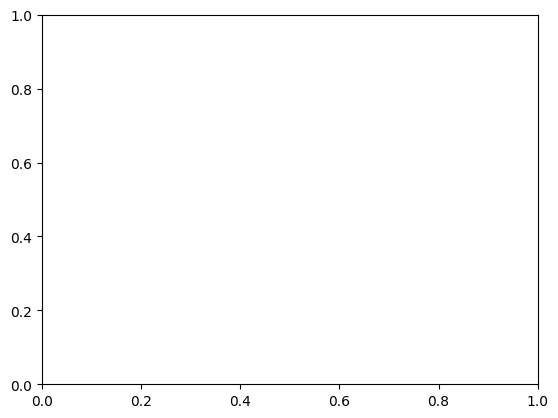

In [23]:
# Calculate mean and std for train and test scores
average_train_scores = aggregated_eval_results.groupby(["classifier", "data_type"])["train_score_mean"].mean()
average_test_scores = aggregated_eval_results.groupby(["classifier", "data_type"])["test_score_mean"].mean()

std_train_scores = aggregated_eval_results.groupby(["classifier", "data_type"])["std_train_score"].mean()
std_test_scores = aggregated_eval_results.groupby(["classifier", "data_type"])["std_test_score"].mean()


# Unpack Series objects into DataFrames (optional)
train_results_df = pd.DataFrame({'mean': average_train_scores, 'std': std_train_scores})
test_results_df = pd.DataFrame({'mean': average_test_scores, 'std': std_test_scores})

# Assuming you have a way to access training sizes (x-axis values) for each group
# train_sizes = # ... (your logic to get training sizes)

# Plot learning curves using the unpacked data and train_sizes
plot_learning_curves(train_results_df, test_results_df, len(train_results_df))  # Assuming plot_learning_curves function is defined
